<a href="https://colab.research.google.com/github/ianritchie-yg/WeightingGUI/blob/main/%5Bnew%5D_adalflow_quick_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤗 Welcome to AdalFlow!
## The AI-first Library to Build and Auto-optimize Any LLM Workflow

We are here to help you build product-grad LLM apps. [Join our community,](https://discord.gg/ezzszrRZvT) ⭐ <i>Star us on <a href="https://github.com/SylphAI-Inc/AdalFlow">Github</a> </i> only if you love us!⭐

## Quick Intro

A component is a building block in AdalFlow. We have three types of components:

* `Component`: Used for LLM workflows. Supports both training and evaluation modes with `forward` (train mode), `call` (eval mode), and `bicall` (supports both eval and train modes).
* `DataComponent`: Supports only eval mode. Used for data processing tasks, such as LLM string parsing, that do not require training.
* `GradComponent`: A unit in the runtime computation graph of LLM-AutoDiff. Supports both `forward` and `backward` operations. Our `Generator` and `Retriever` are `GradComponent`.

In [ ]:
from IPython.display import clear_output

!pip install -U adalflow[openai,groq,datasets]

clear_output()

Setup API Keys

*Go to [OpenAI](https://platform.openai.com/docs/introduction) and [Groq](https://console.groq.com/docs/) to get API keys if you don't already have.*

Create `.env` file with `OPENAI_API_KEY` and `GROQ_API_KEY` setup.

In [ ]:
import adalflow as adal
from adalflow.utils import setup_env

setup_env()

print("API keys have been set.")

API keys have been set.


In [ ]:
# or you can input the keys here

# import os

# from getpass import getpass


# OPENAI_API_KEY = getpass("Please enter your OpenAI API key: ")
# TOGETHER_API_KEY = getpass("Please enter your Together API key: ")


# os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
# os.environ["TOGETHER_API_KEY"] = TOGETHER_API_KEY

# print("API keys have been set.")



# 😇 Build a task workflow




In [ ]:
import re
from typing import Dict, Union
from adalflow.optim.types import ParameterType


# jinja2 prompt template

few_shot_template = r"""<START_OF_SYSTEM_PROMPT>
{{system_prompt}}
{# Few shot demos #}
{% if few_shot_demos is not none %}
Here are some examples:
{{few_shot_demos}}
{% endif %}
<END_OF_SYSTEM_PROMPT>
<START_OF_USER>
{{input_str}}
<END_OF_USER>
"""

# customize parser, using the func_to_data_component to convert to a component.

@adal.func_to_data_component
def parse_integer_answer(answer: str):
    try:
        numbers = re.findall(r"\d+", answer)
        if numbers:
            answer = int(numbers[-1])
        else:
            answer = -1
    except ValueError:
        answer = -1

    return answer



# Define the task.
# this allows us using both LLM-AutoDiff and few-shot learning.

class ObjectCountTaskPipeline(adal.Component):
    def __init__(self, model_client: adal.ModelClient, model_kwargs: Dict):
        super().__init__()

        system_prompt = adal.Parameter(
            data="You will answer a reasoning question. Think step by step. The last line of your response should be of the following format: 'Answer: $VALUE' where VALUE is a numerical value.",
            role_desc="To give task instruction to the language model in the system prompt",
            requires_opt=True,
            param_type=ParameterType.PROMPT,
        )
        few_shot_demos = adal.Parameter(
            data=None,
            role_desc="To provide few shot demos to the language model",
            requires_opt=True,  # Changed to True for few-shot learning
            param_type=ParameterType.DEMOS,
        )

        self.llm_counter = adal.Generator(
            model_client=model_client,
            model_kwargs=model_kwargs,
            template=few_shot_template,
            prompt_kwargs={
                "system_prompt": system_prompt,
                "few_shot_demos": few_shot_demos,
            },
            output_processors=parse_integer_answer,
            use_cache=True,
        )

    def bicall(
        self, question: str, id: str = None
    ) -> Union[adal.GeneratorOutput, adal.Parameter]:
        """Trainer can use bicall in both train and eval mode"""
        output = self.llm_counter(prompt_kwargs={"input_str": question}, id=id)
        return output

# 🥰 Define all models to use

In [ ]:
from adalflow.components.model_client.openai_client import OpenAIClient
from adalflow.components.model_client.groq_client import GroqAPIClient

gpt_3_model = {
        "model_client": OpenAIClient(),
        "model_kwargs": {
            "model": "gpt-3.5-turbo-0125",
            "temperature": 0.0,
            "top_p": 0.99,
            "frequency_penalty": 0,
            "presence_penalty": 0,
            "stop": None,
        },
    }

deepseek_r1  = {
    "model_client": GroqAPIClient(),
    "model_kwargs": {
        "model": "deepseek-r1-distill-llama-70b",
    },
}


gpt_o3_mini_model = {
    "model_client": OpenAIClient(),
    "model_kwargs": {
        "model": "o3-mini",
        "temperature": 1.0,
    },
}

In [ ]:
question = "I have a yam, a cauliflower, a bed, two cabbages, a garlic, an oven, a carrot, a head of broccoli, a potato, a stalk of celery, a lettuce head, and a toaster. How many vegetables do I have?"
object_counter = ObjectCountTaskPipeline(**gpt_3_model)

answer = object_counter(question, id="1")
print(answer)

GeneratorOutput(id='1', data=9, error=None, usage=CompletionUsage(completion_tokens=87, prompt_tokens=123, total_tokens=210), raw_response='To find the number of vegetables you have, we need to count the individual vegetables from the list provided. Based on the list you have provided, you have the following vegetables: yam, cauliflower, two cabbages, garlic, carrot, head of broccoli, potato, stalk of celery, and lettuce head.\n\nCounting these individual vegetables, we find that you have a total of 9 different vegetables.\n\nAnswer: 9', metadata=None)


# 😊 Load Datasets

In [ ]:
from adalflow.datasets.big_bench_hard import BigBenchHard


def load_datasets():
    train_data = BigBenchHard(split="train")
    val_data = BigBenchHard(split="val")
    test_data = BigBenchHard(split="test")

    return train_data, val_data, test_data

In [ ]:
# check the datasets

train_data, val_data, test_data = load_datasets()
print(train_data[0])

Saving train split to /root/.adalflow/cache_datasets/object_counting/train.csv
Saving val split to /root/.adalflow/cache_datasets/object_counting/val.csv
Saving test split to /root/.adalflow/cache_datasets/object_counting/test.csv
Example(id='187dac84-61df-4371-95c1-2a3decd46d9e', question='I have a flute, a piano, a trombone, four stoves, a violin, an accordion, a clarinet, a drum, two lamps, and a trumpet. How many musical instruments do I have?', answer='8')


# 🤯 Train

We will use train dataset to sample or run LLM-AutoDiff.
Eval dataset is used for validation in each step.
Test dataset is only run at the beginning and at the end for the final performance.

*Note: Each run can be a bit random*

In [ ]:
from adalflow.datasets.types import Example
from adalflow.eval.answer_match_acc import AnswerMatchAcc
from adalflow.datasets.types import Example

# define task, eval_fn here
class ObjectCountAdalComponent(adal.AdalComponent):  # noqa: F811
    def __init__(
        self,
        model_client: adal.ModelClient,
        model_kwargs: Dict,
        backward_engine_model_config: Dict,
        teacher_model_config: Dict,
        text_optimizer_model_config: Dict,
    ):
        task = ObjectCountTaskPipeline(model_client, model_kwargs)
        eval_fn = AnswerMatchAcc(type="exact_match").compute_single_item
        loss_fn = adal.EvalFnToTextLoss(
            eval_fn=eval_fn,
            eval_fn_desc="exact_match: 1 if str(y) == str(y_gt) else 0",
        )
        super().__init__(task=task, eval_fn=eval_fn, loss_fn=loss_fn)

        self.backward_engine_model_config = backward_engine_model_config
        self.teacher_model_config = teacher_model_config
        self.text_optimizer_model_config = text_optimizer_model_config

    def prepare_task(self, sample: Example):
        return self.task.bicall, {"question": sample.question, "id": sample.id}

    def prepare_eval(self, sample: Example, y_pred: adal.GeneratorOutput) -> float:
        y_label = -1
        if (
            y_pred is not None and y_pred.data is not None
        ):
            y_label = y_pred.data
        return self.eval_fn, {"y": y_label, "y_gt": sample.answer}

    def prepare_loss(self, sample: Example, pred: adal.Parameter):
        y_gt = adal.Parameter(
            name="y_gt",
            data=sample.answer,
            eval_input=sample.answer,
            requires_opt=False,
        )

        pred.eval_input = pred.full_response.data
        return self.loss_fn, {"kwargs": {"y": pred, "y_gt": y_gt}, "id": sample.id}

In [ ]:
def train(task_model_config=gpt_3_model, optimizer_model_config=gpt_o3_mini_model):
  adal_component = ObjectCountAdalComponent(
      **task_model_config,
      teacher_model_config=optimizer_model_config,
      text_optimizer_model_config=optimizer_model_config,
      backward_engine_model_config=optimizer_model_config,
  )
  trainer = adal.Trainer(
      adaltask=adal_component,
      max_steps=12, # 12 steps of LLM-AutoDiff, and 12 steps of few-shot learning(2)
      raw_shots=1,
      bootstrap_shots=1,
      strategy="random",
  )

  train_dataset, val_dataset, test_dataset = load_datasets()
  trainer.fit(
      train_dataset=train_dataset,
      val_dataset=val_dataset,
      test_dataset=test_dataset,
  )

In [ ]:
train() # 0.78 val, 0.8 on the test before training.



raw_shots: 1, bootstrap_shots: 1
BootstrapFewShot: ['llm_counter.few_shot_demos']
2025-02-10 02:14:25 - [adal.py:852:configure_text_optimizer_helper] - Text optimizer configured for 1 parameters. names: [('llm_counter.system_prompt', "You will answer a reasoning question. Think step by step. The last line of your response should be of the following format: 'Answer: $VALUE' where VALUE is a numerical value.")]
Configuring teacher generator.
Configuring teacher generator for Generator(
  model_kwargs={'model': 'o3-mini', 'temperature': 1.0}, trainable_prompt_kwargs=[], prompt=template: <START_OF_SYSTEM_PROMPT>
  {{system_prompt}}
  {# Few shot demos #}
  {% if few_shot_demos is not none %}
  Here are some examples:
  {{few_shot_demos}}
  {% endif %}
  <END_OF_SYSTEM_PROMPT>
  <START_OF_USER>
  {{input_str}}
  <END_OF_USER>
  , prompt_kwargs: {'system_prompt': "You will answer a reasoning question. Think step by step. The last line of your response should be of the following format: 'Answ


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 8146.81it/s]
Predicting: step(0): 0.78 across 100 samples, Max potential: 0.78: 100%|██████████| 100/100 [00:00<00:00, 274.63it/s]

Loading Data: 100%|██████████| 100/100 [00:00<00:00, 15195.65it/s]
Predicting: step(0): 0.8 across 100 samples, Max potential: 0.8: 100%|██████████| 100/100 [00:00<00:00, 512.30it/s]


Initial validation score: 0.78
Initial test score: 0.8
_fit_text_grad_random save to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json
num_epochs: 1, max_steps: 12



Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0


Training Step: 1:   0%|          | 0/13 [00:00<?, ?it/s]

Training: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 5819.36it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 4019.46it/s]

Proposal: 1


2025-02-10 02:14:54 - [trainer.py:1690:_random_propose_step] - Propose time: 5.209125280380249
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step and carefully verify all arithmetic calculations before providing your answer. The last line of your response should be of the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1028.39it/s]
Predicting: step(1): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


2025-02-10 02:14:57 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 0.75





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 6545.21it/s]
Predicting: step(1): 0.89 across 100 samples, Max potential: 0.89: 100%|██████████| 100/100 [00:24<00:00,  4.07it/s]
Training Step: 2:   8%|▊         | 1/13 [00:55<11:03, 55.31s/it]

Optimizer step: 0.89 > 0.78
 1, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 1272.93it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 2151.75it/s]

Proposal: 1


2025-02-10 02:15:47 - [trainer.py:1690:_random_propose_step] - Propose time: 4.094173431396484
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step and carefully verify all arithmetic calculations before providing your answer. For questions involving the classification of produce, note that only items that are botanical vegetables (such as broccoli, lettuce, cauliflower, celery, garlic, cabbage, yam, potato, etc.) should be counted as vegetables. Fruits (e.g., apples, oranges, bananas) must be excluded unless explicitly stated otherwise. The last line of your response should be of the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 294.36it/s]
Predicting: step(2): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


Proposing:  20%|██        | 1/5 [00:06<00:25,  6.35s/it]

2025-02-10 02:15:49 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 0.75
Proposal: 2
2025-02-10 02:15:53 - [trainer.py:1690:_random_propose_step] - Propose time: 4.056713581085205
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a reasoning question about counting edible items. Think step by step and carefully verify all arithmetic calculations before providing your answer. Only count items that are considered botanical vegetables (for example, broccoli, lettuce, cauliflower, etc.) and exclude fruits (such as apples, oranges, etc.) unless they are explicitly identified as vegetables. The final line of your response must be exactly: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1180.33it/s]
Predicting: step(2): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Proposing:  40%|████      | 2/5 [00:12<00:19,  6.41s/it]

2025-02-10 02:15:55 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.5 <= 0.75
Proposal: 3
2025-02-10 02:16:05 - [trainer.py:1690:_random_propose_step] - Propose time: 10.085594654083252
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will answer a reasoning question. Provide a detailed, step-by-step explanation of your thought process and carefully verify all arithmetic calculations before providing your final answer. For questions involving the counting of vegetables, count only botanical vegetables and exclude fruits. For example, if the input is: "I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?", you should count only the broccoli, lettuce, and onions (2 + 1 + 2 = 5) and produce a final line in the following format: \'Answer: 5\'. The last line of your response must always be of the format: \'Answer: $VALUE\' where VALUE is




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1270.52it/s]
Predicting: step(2): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Proposing:  60%|██████    | 3/5 [00:26<00:19,  9.63s/it]

2025-02-10 02:16:09 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 0.75
Proposal: 4
2025-02-10 02:16:29 - [trainer.py:1690:_random_propose_step] - Propose time: 20.552452325820923
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a question. Think step by step. The last line of your response should be in the format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 409.87it/s]
Predicting: step(2): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


2025-02-10 02:16:32 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 0.75





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 8262.20it/s]
Predicting: step(2): 0.75 across 44 samples, Max potential: 0.89:  44%|████▍     | 44/100 [00:27<00:34,  1.60it/s]


Proposing:  80%|████████  | 4/5 [01:17<00:25, 25.97s/it]

Optimizer revert: 0.7333333333333333 <= 0.89
Proposal: 5
2025-02-10 02:17:15 - [trainer.py:1690:_random_propose_step] - Propose time: 15.258435249328613
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a reasoning question. Begin by listing each item provided in the question as a bullet point and determine if it qualifies as a vegetable based on botanical classification (exclude fruits such as apples unless explicitly stated otherwise). Then, sum only the items confirmed as vegetables. Think step by step and verify all arithmetic calculations before providing your final answer. The last line of your response must be in the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1824.80it/s]
Predicting: step(2): 0.25 across 4 samples, Max potential: 0.25: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


Training Step: 3:  15%|█▌        | 2/13 [02:50<16:36, 90.56s/it]

2025-02-10 02:17:17 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.25 <= 0.75
No proposal can improve the subset and full set, and val set
 2, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.93it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 10143.42it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 2256.52it/s]

Proposal: 1


2025-02-10 02:17:35 - [trainer.py:1690:_random_propose_step] - Propose time: 5.557391405105591
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a quantitative reasoning question. Think through the problem step by step, clearly showing your chain-of-thought, and double-check all arithmetic operations before providing your answer. The final line of your response must be in the format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2071.01it/s]
Predicting: step(3): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:01<00:00,  2.43it/s]


Proposing:  20%|██        | 1/5 [00:07<00:29,  7.36s/it]

2025-02-10 02:17:37 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 2
2025-02-10 02:17:42 - [trainer.py:1690:_random_propose_step] - Propose time: 5.4184253215789795
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step and carefully verify all arithmetic calculations before providing your answer. After performing your computations, please double-check each calculation for accuracy. The final line of your response must be in the following format: 'Answer: $VALUE' where VALUE is the numerical result.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 304.27it/s]
Predicting: step(3): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


2025-02-10 02:17:44 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3551.15it/s]
Predicting: step(3): 0.7105 across 38 samples, Max potential: 0.89:  38%|███▊      | 38/100 [00:25<00:41,  1.49it/s]


Proposing:  40%|████      | 2/5 [00:40<01:07, 22.57s/it]

Optimizer revert: 0.6923076923076923 <= 0.89
Proposal: 3
2025-02-10 02:18:17 - [trainer.py:1690:_random_propose_step] - Propose time: 6.9969871044158936
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a reasoning question. Start by identifying all objects and their counts, then carefully verify your arithmetic by reviewing each addition step. Provide a clear explanation of your reasoning, and finally, on a new line, output your result in the exact format: 'Answer: $VALUE', where VALUE is a numerical value. For example, if the input is 'I have 2 apples and 3 oranges', your response should be: 'To compute the total, add 2 (apples) + 3 (oranges) = 5\\nAnswer: 5'.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 260.76it/s]
Predicting: step(3): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Proposing:  60%|██████    | 3/5 [00:53<00:35, 17.97s/it]

2025-02-10 02:18:22 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 4
2025-02-10 02:18:28 - [trainer.py:1690:_random_propose_step] - Propose time: 5.2725114822387695
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a reasoning question. Solve the problem step by step, verifying every arithmetic operation before responding. Provide your final answer strictly on the last line in the following format: 'Answer: $VALUE' (where $VALUE is a numerical result) without any additional commentary.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1059.37it/s]
Predicting: step(3): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


Proposing:  80%|████████  | 4/5 [01:00<00:13, 13.78s/it]

2025-02-10 02:18:30 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 5
2025-02-10 02:18:42 - [trainer.py:1690:_random_propose_step] - Propose time: 12.139230966567993
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You are a precise arithmetic reasoning expert. For each problem, provide a detailed, numbered list of steps that includes: (1) identifying and listing each numerical quantity; (2) performing and clearly showing each arithmetic operation; and (3) immediately verifying each calculation before proceeding. After completing all steps, double-check your final result and display it on a separate line exactly in the following format: 'Answer: $VALUE' (where $VALUE is the computed numerical result). Do not add any extra commentary beyond the outlined steps.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 3038.80it/s]
Predicting: step(3): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


2025-02-10 02:18:44 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5679.80it/s]
Predicting: step(3): 0.7317 across 41 samples, Max potential: 0.89:  41%|████      | 41/100 [00:31<00:45,  1.29it/s]


Training Step: 4:  23%|██▎       | 3/13 [04:49<17:16, 103.63s/it]

Optimizer revert: 0.7142857142857143 <= 0.89
No proposal can improve the subset and full set, and val set
 3, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 10369.11it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 1678.39it/s]

Proposal: 1


2025-02-10 02:19:41 - [trainer.py:1690:_random_propose_step] - Propose time: 9.6457998752594
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a reasoning question. Begin with a detailed, step-by-step explanation and carefully verify all arithmetic calculations before arriving at your answer. Ensure that the final line of your response strictly follows this format: 'Answer: $VALUE' (replace $VALUE with the numerical result).", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 286.02it/s]
Predicting: step(4): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


2025-02-10 02:19:43 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3168.50it/s]
Predicting: step(4): 0.75 across 44 samples, Max potential: 0.89:  44%|████▍     | 44/100 [00:29<00:38,  1.47it/s]


Proposing:  20%|██        | 1/5 [00:42<02:49, 42.35s/it]

Optimizer revert: 0.7333333333333333 <= 0.89
Proposal: 2
2025-02-10 02:20:21 - [trainer.py:1690:_random_propose_step] - Propose time: 8.123241424560547
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step and carefully verify all arithmetic calculations before providing your answer. Note: If your chain-of-thought reasoning involves more than three distinct steps, update your final answer more rapidly once all steps have been consolidated. The last line of your response should be of the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 755.19it/s]
Predicting: step(4): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Proposing:  40%|████      | 2/5 [00:52<01:09, 23.18s/it]

2025-02-10 02:20:23 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 3
2025-02-10 02:20:30 - [trainer.py:1690:_random_propose_step] - Propose time: 6.6576173305511475
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step and carefully verify all arithmetic calculations before providing your answer. If your chain-of-thought involves more than three distinct steps, update the final answer more rapidly. Ensure that the last line of your response follows this exact format: 'Answer: $VALUE' where VALUE is a numerical value. For example, if the input is 'I have 3 apples and 4 oranges, how many fruits do I have?', your detailed reasoning might be: Step 1: Count apples = 3; Step 2: Count oranges = 4; Step 3: Compute total: 3 + 4 = 7; and the final output should be 'Answer: 7'.", requires_opt=True), PromptData(id='1a5aaf0a-e




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 413.71it/s]
Predicting: step(4): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Proposing:  60%|██████    | 3/5 [01:01<00:33, 16.69s/it]

2025-02-10 02:20:32 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 4
2025-02-10 02:20:39 - [trainer.py:1690:_random_propose_step] - Propose time: 7.303040981292725
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="Answer a reasoning and arithmetic question by thinking step by step and verifying all calculations. If your chain-of-thought comprises more than three distinct steps, update the final value more rapidly. End your response with a line exactly as: 'Answer: $VALUE', where VALUE is the numerical result.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1234.71it/s]
Predicting: step(4): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]


2025-02-10 02:20:41 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 9695.35it/s]
Predicting: step(4): 0.8514 across 74 samples, Max potential: 0.89:  74%|███████▍  | 74/100 [00:25<00:08,  2.93it/s]


Proposing:  80%|████████  | 4/5 [01:35<00:23, 23.63s/it]

Optimizer revert: 0.84 <= 0.89
Proposal: 5
2025-02-10 02:21:16 - [trainer.py:1690:_random_propose_step] - Propose time: 10.11445164680481
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying every arithmetic calculation carefully. If your chain-of-thought involves more than three distinct steps, promptly update the running total as soon as new information is processed. Ensure your final answer is provided on the last line in the exact format: 'Answer: $VALUE', where VALUE is the numerical result.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2069.47it/s]
Predicting: step(4): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


2025-02-10 02:21:18 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Proposing:  80%|████████  | 4/5 [02:15<00:33, 33.95s/it]
Predicting: step(4): 0.9 across 100 samples, Max potential: 0.9: 100%|██████████| 100/100 [00:28<00:00,  3.54it/s]
Training Step: 5:  31%|███       | 4/13 [07:20<18:20, 122.31s/it]

Optimizer step: 0.9 > 0.89
 4, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 1024.31it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 2714.32it/s]

Proposal: 1


2025-02-10 02:22:06 - [trainer.py:1690:_random_propose_step] - Propose time: 4.848792314529419
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying every arithmetic calculation carefully. If your chain-of-thought involves more than three distinct steps, promptly update the running total as soon as new information is processed, ensuring that no more than three steps occur without updating. Ensure your final answer is provided on the last line in the exact format: 'Answer: $VALUE', where VALUE is the numerical result.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 211.09it/s]
Predicting: step(5): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Proposing:  20%|██        | 1/5 [00:07<00:30,  7.68s/it]

2025-02-10 02:22:09 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 2
2025-02-10 02:22:15 - [trainer.py:1690:_random_propose_step] - Propose time: 6.525821685791016
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You are a precise arithmetic expert. For each reasoning question, break down your solution into explicit, step-by-step calculations, verifying every arithmetic operation accurately. If your chain-of-thought involves more than three distinct steps, update the running total immediately with each new calculation. Provide your final answer on the last line in the exact format: 'Answer: $VALUE', where VALUE is the numerical result.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 470.16it/s]
Predicting: step(5): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


2025-02-10 02:22:18 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 2943.37it/s]
Predicting: step(5): 0.7727 across 44 samples, Max potential: 0.9:  44%|████▍     | 44/100 [00:27<00:35,  1.59it/s]


Proposing:  40%|████      | 2/5 [00:44<01:14, 24.84s/it]

Optimizer revert: 0.7555555555555555 <= 0.9
Proposal: 3
2025-02-10 02:22:52 - [trainer.py:1690:_random_propose_step] - Propose time: 6.251848220825195
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, immediately update the running total with each new piece of information. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\nFinally, ensure that the last line of your output is exactly in the format: \'Answer: $VALUE\', where VALUE is the computed numerical result.', requires




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 428.37it/s]
Predicting: step(5): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:06<00:00,  1.50s/it]


2025-02-10 02:22:58 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5911.88it/s]
Predicting: step(5): 0.95 across 100 samples, Max potential: 0.95: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]
Training Step: 6:  38%|███▊      | 5/13 [08:59<15:10, 113.84s/it]

Optimizer step: 0.95 > 0.9
 5, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 335.63it/s]
Predicting: step(6): 0.8246 across 57 samples, Max potential: 0.9:  57%|█████▋    | 57/100 [10:06<07:37, 10.65s/it]
Training: 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 5093.27it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 8464.79it/s]

Proposal: 1


2025-02-10 02:23:49 - [trainer.py:1690:_random_propose_step] - Propose time: 8.582945108413696
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct arithmetic operations, immediately update the running total after each additional operation to reflect cumulative progress. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\n\nFinally, ensure that the last line of your output is exactly in the format: \'Answer: $VALUE\', where VALUE is the computed numerical result.', requires_opt=Tru




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 348.37it/s]
Predicting: step(6): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


2025-02-10 02:23:52 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3656.63it/s]
Predicting: step(6): 0.9315 across 73 samples, Max potential: 0.95:  73%|███████▎  | 73/100 [00:31<00:11,  2.29it/s]


Proposing:  20%|██        | 1/5 [00:43<02:53, 43.37s/it]

Optimizer revert: 0.918918918918919 <= 0.95
Proposal: 2
2025-02-10 02:24:30 - [trainer.py:1690:_random_propose_step] - Propose time: 6.228816509246826
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='Assume the role of a precise arithmetic expert. When presented with an arithmetic problem, work through the solution step by step, verifying each calculation carefully. If your chain-of-thought extends beyond three distinct steps, update the cumulative total immediately after processing each additional step. For example, for the query "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", proceed as follows:\n\n1. Begin with 2 apples.\n2. Add 3 bananas to update the total to 5.\n3. With 4 cherries, immediately update the total: 5 + 4 = 9.\n\nEnsure that the final line of your output is exactly in the format: \'Answer: 9\', where 9 represents the computed numerical result.', requires_opt=True), PromptData(id='1a5




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 127.07it/s]
Predicting: step(6): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


2025-02-10 02:24:34 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4702.61it/s]
Predicting: step(6): 0.9123 across 57 samples, Max potential: 0.95:  57%|█████▋    | 57/100 [00:29<00:22,  1.93it/s]


Proposing:  40%|████      | 2/5 [01:23<02:03, 41.18s/it]

Optimizer revert: 0.896551724137931 <= 0.95
Proposal: 3
2025-02-10 02:25:10 - [trainer.py:1690:_random_propose_step] - Propose time: 5.91035532951355
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. When solving a reasoning problem, provide a clear, step-by-step chain-of-thought, verifying every arithmetic calculation. If the problem involves more than three distinct steps, update the running total immediately after processing each new piece of information (i.e., starting from step 4, each step must include an immediate update of the cumulative sum). For example, given the question "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your response should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the running total to 5.\n3. Process 4 cherries, immediately updating the total: 5 + 4 = 9.\n\nEnsure that your final answer is provided on the last line




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2089.84it/s]
Predicting: step(6): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


2025-02-10 02:25:13 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3520.10it/s]
Predicting: step(6): 0.95 across 100 samples, Max potential: 0.95: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


Proposing:  60%|██████    | 3/5 [02:03<01:21, 40.64s/it]

Optimizer revert: 0.95 <= 0.95
Proposal: 4
2025-02-10 02:25:51 - [trainer.py:1690:_random_propose_step] - Propose time: 7.207509994506836
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. When answering a reasoning question, work through your solution step by step, verifying every arithmetic calculation. If your process involves more than three distinct steps, update the running total immediately after processing each new piece of numerical information. For example, if the question is "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your response should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\n\nFinally, ensure your output concludes with a line exactly formatted as: \'Answer: $VALUE\', where VALUE is the computed numerical result.', requires_opt=True), 




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 340.02it/s]
Predicting: step(6): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Proposing:  80%|████████  | 4/5 [02:12<00:28, 28.54s/it]

2025-02-10 02:25:54 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 5
2025-02-10 02:26:01 - [trainer.py:1690:_random_propose_step] - Propose time: 7.320001125335693
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You are a precise arithmetic expert. When solving a reasoning question, follow these rules:\n- Start with the initial total provided in the question.\n- Process each arithmetic operation in clear, distinct steps.\n- If your solution exceeds three steps, update the running total immediately after each additional step.\n- Present your working as individual steps.\n- The final line must be exactly: 'Answer: $VALUE', where $VALUE is your computed result.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 306.84it/s]
Predicting: step(6): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Training Step: 7:  46%|████▌     | 6/13 [11:37<15:02, 128.98s/it]

2025-02-10 02:26:04 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
No proposal can improve the subset and full set, and val set
 6, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  3.42it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 9686.61it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 2609.21it/s]

Proposal: 1


2025-02-10 02:26:30 - [trainer.py:1690:_random_propose_step] - Propose time: 7.461618185043335
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. When solving a reasoning question, work through your solution step by step while carefully verifying every arithmetic calculation. If your chain-of-thought involves more than three distinct steps, immediately update the running total as soon as new information is processed. For example, if you are asked: "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your response should be as follows:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately calculate and update the total: 5 + 4 = 9.\n\nFinally, ensure that the last line of your output is exactly in the following format: "Answer: $VALUE", where $VALUE is the computed numerical result.', requires_opt=True), P




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 486.47it/s]
Predicting: step(7): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


2025-02-10 02:26:32 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4825.42it/s]
Predicting: step(7): 0.9468 across 94 samples, Max potential: 0.95:  94%|█████████▍| 94/100 [00:23<00:01,  3.96it/s]


Proposing:  20%|██        | 1/5 [00:33<02:13, 33.48s/it]

Optimizer revert: 0.9368421052631579 <= 0.95
Proposal: 2
2025-02-10 02:27:02 - [trainer.py:1690:_random_propose_step] - Propose time: 6.862418174743652
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each arithmetic operation without waiting for the complete chain-of-thought. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\nFinally, ensure that the last line of your output is exactly in the format: \'Answer: $VALUE\




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 304.86it/s]
Predicting: step(7): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s]


Proposing:  40%|████      | 2/5 [00:42<00:57, 19.21s/it]

2025-02-10 02:27:05 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 3
2025-02-10 02:27:14 - [trainer.py:1690:_random_propose_step] - Propose time: 8.78452467918396
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct arithmetic steps, immediately update the running total as new values are processed. For example, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the running total: 5 + 4 = 9.\n\nAnother example: When asked "I have 3 oranges, 5 apples, and 2 p




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 715.72it/s]
Predicting: step(7): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


2025-02-10 02:27:16 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4327.77it/s]
Predicting: step(7): 0.8958 across 48 samples, Max potential: 0.95:  48%|████▊     | 48/100 [00:27<00:29,  1.75it/s]


Proposing:  60%|██████    | 3/5 [01:21<00:55, 27.95s/it]

Optimizer revert: 0.8775510204081632 <= 0.95
Proposal: 4
2025-02-10 02:27:50 - [trainer.py:1690:_random_propose_step] - Propose time: 6.694586277008057
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. Answer reasoning questions by computing arithmetic values step by step, verifying each calculation. If your chain-of-thought involves more than three arithmetic operations, update the running total immediately after each operation. For example, given the question "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your process should be:\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5 immediately.\n3. Add 4 cherries, updating the total: 5 + 4 = 9 immediately.\nProvide your final answer on the last line exactly as: \'Answer: $VALUE\'.', requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', d




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1434.93it/s]
Predicting: step(7): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


Proposing:  80%|████████  | 4/5 [01:30<00:20, 20.46s/it]

2025-02-10 02:27:52 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 5
2025-02-10 02:28:01 - [trainer.py:1690:_random_propose_step] - Propose time: 8.897119283676147
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. For each reasoning question, break down the arithmetic into clear step-by-step operations while verifying every calculation. When your chain-of-thought includes more than three arithmetic steps, update the running total immediately after each new calculation. For instance, given the question "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your process should be:\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\nFinally, ensure that the last line of your output is exactly in the format: \'Answer:




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 704.95it/s]
Predicting: step(7): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]


Training Step: 8:  54%|█████▍    | 7/13 [13:37<12:34, 125.81s/it]

2025-02-10 02:28:03 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
No proposal can improve the subset and full set, and val set
 7, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 4053.45it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 5888.81it/s]

Proposal: 1


2025-02-10 02:28:29 - [trainer.py:1690:_random_propose_step] - Propose time: 7.7144482135772705
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying every arithmetic calculation as you go. If your chain-of-thought involves more than three distinct steps, update the running total immediately after calculating each new piece of information. For example, if you are asked, "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\nFinally, ensure that the last line of your output is exactly in the format: \'Answer: $VALUE\', where VALUE is the computed numerical result.', requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 970.45it/s]
Predicting: step(8): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


2025-02-10 02:28:31 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 2599.49it/s]
Predicting: step(8): 0.9286 across 70 samples, Max potential: 0.95:  70%|███████   | 70/100 [00:25<00:10,  2.75it/s]


Proposing:  20%|██        | 1/5 [00:35<02:21, 35.37s/it]

Optimizer revert: 0.9154929577464789 <= 0.95
Proposal: 2
2025-02-10 02:29:06 - [trainer.py:1690:_random_propose_step] - Propose time: 8.684950113296509
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step-by-step, carefully verifying every arithmetic calculation. If your chain-of-thought consists of more than three distinct arithmetic operations, update the running total immediately after each operation. For example, for a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your solution should be:\n1. Start with 2 apples.\n2. Add 3 bananas; update the total: 2 + 3 = 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\nAs an additional illustration for a chain with four steps, consider the sequence "Start with 5, add 2, add 3, and add 1":\n1. Start with 5.\n2.




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 333.44it/s]
Predicting: step(8): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


2025-02-10 02:29:08 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5518.82it/s]
Predicting: step(8): 0.9405 across 84 samples, Max potential: 0.95:  84%|████████▍ | 84/100 [00:33<00:06,  2.55it/s]


Proposing:  40%|████      | 2/5 [01:19<02:01, 40.53s/it]

Optimizer revert: 0.9294117647058824 <= 0.95
Proposal: 3
2025-02-10 02:29:47 - [trainer.py:1690:_random_propose_step] - Propose time: 5.807683944702148
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct arithmetic operations, update the running total immediately after each operation without delay. For instance, if you receive a question like 'I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?', your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\n\nEnsure your final output concludes with a line exactly in the format: 'Answer: $VALUE', where VALUE is the computed numerical resul




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 939.69it/s]
Predicting: step(8): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


2025-02-10 02:29:49 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 7285.83it/s]
Predicting: step(8): 0.9315 across 73 samples, Max potential: 0.95:  73%|███████▎  | 73/100 [00:28<00:10,  2.54it/s]


Proposing:  60%|██████    | 3/5 [01:56<01:17, 38.95s/it]

Optimizer revert: 0.918918918918919 <= 0.95
Proposal: 4
2025-02-10 02:30:24 - [trainer.py:1690:_random_propose_step] - Propose time: 5.320708274841309
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data="You will act as a precise arithmetic expert. Solve each reasoning problem step by step and verify every arithmetic calculation. If your chain-of-thought involves more than three distinct steps, update the running total immediately after every arithmetic operation. For example, for the question 'I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?':\n1. Start with 2 apples.\n2. Add 3 bananas to reach 5.\n3. Add 4 cherries to reach 9.\nFinally, ensure your output ends precisely with the line: 'Answer: $VALUE', where VALUE is the computed total.", requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 591.39it/s]
Predicting: step(8): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


2025-02-10 02:30:25 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4747.86it/s]
Predicting: step(8): 0.9468 across 94 samples, Max potential: 0.95:  94%|█████████▍| 94/100 [00:24<00:01,  3.79it/s]


Proposing:  80%|████████  | 4/5 [02:28<00:36, 36.24s/it]

Optimizer revert: 0.9368421052631579 <= 0.95
Proposal: 5
2025-02-10 02:30:55 - [trainer.py:1690:_random_propose_step] - Propose time: 4.850379467010498
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. When solving a reasoning question, break your process into clear consecutive steps and validate every arithmetic calculation. If you have more than three steps, update the running total immediately after each additional arithmetic operation. For example, if you are asked: "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your procedure should be:\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Process 4 cherries and immediately update the total: 5 + 4 = 9.\nYour final output must finish with an exact line of the form: \'Answer: 9\', where 9 is the computed total.', requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1',




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 270.67it/s]
Predicting: step(8): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]


2025-02-10 02:30:58 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4032.33it/s]
Predicting: step(8): 0.9153 across 59 samples, Max potential: 0.95:  59%|█████▉    | 59/100 [00:31<00:21,  1.87it/s]


Training Step: 9:  62%|██████▏   | 8/13 [17:03<12:37, 151.46s/it]

Optimizer revert: 0.9 <= 0.95
No proposal can improve the subset and full set, and val set
 8, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 1502.93it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 1673.04it/s]

Proposal: 1


2025-02-10 02:31:53 - [trainer.py:1690:_random_propose_step] - Propose time: 6.755395412445068
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\n\nFinally, ensure that the last line of your output is exactly in the format: \'Answer: $VALUE\', where VALUE is the computed numerical result.', requires_opt=True), Prom




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 276.49it/s]
Predicting: step(9): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


2025-02-10 02:31:55 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3844.32it/s]
Predicting: step(9): 0.96 across 100 samples, Max potential: 0.96: 100%|██████████| 100/100 [00:30<00:00,  3.30it/s]
Training Step: 10:  69%|██████▉   | 9/13 [17:59<08:06, 121.54s/it]

Optimizer step: 0.96 > 0.95
 9, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 473.75it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 1625.23it/s]

Proposal: 1


2025-02-10 02:32:47 - [trainer.py:1690:_random_propose_step] - Propose time: 4.902119874954224
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—ensuring rapid updates when the chain-of-thought is lengthy. For example, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\n\nFinally, ensure that the last line of your output is exactly in the format: \'Answer: $VALUE\', where VALUE is the computed numerical result.'




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 882.50it/s]
Predicting: step(10): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


2025-02-10 02:32:50 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4223.70it/s]
Predicting: step(10): 0.9452 across 73 samples, Max potential: 0.96:  73%|███████▎  | 73/100 [00:30<00:11,  2.41it/s]


Proposing:  20%|██        | 1/5 [00:37<02:31, 37.94s/it]

Optimizer revert: 0.9324324324324325 <= 0.96
Proposal: 2
2025-02-10 02:33:31 - [trainer.py:1690:_random_propose_step] - Propose time: 10.521936893463135
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In your responses to arithmetic reasoning questions, work through your solution step by step with a clear chain-of-thought, verifying every arithmetic calculation. If your solution involves more than three distinct steps, update the running total immediately after processing each additional step — do not wait until the final step. For example, if a problem states "I have 3 oranges, 4 apples, and 5 bananas. How many fruits do I have?", your approach should be:\n\n1. Start with 3 oranges.\n2. Add 4 apples, updating the total to 7.\n3. Upon processing 5 bananas (since this is the fourth step), immediately update the total: 7 + 5 = 12.\n\nEnsure that the last line of your output is exactl




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 321.46it/s]
Predicting: step(10): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


2025-02-10 02:33:33 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3314.92it/s]
Predicting: step(10): 0.9298 across 57 samples, Max potential: 0.96:  57%|█████▋    | 57/100 [00:28<00:21,  2.03it/s]


Proposing:  40%|████      | 2/5 [01:19<01:59, 39.78s/it]

Optimizer revert: 0.9137931034482759 <= 0.96
Proposal: 3
2025-02-10 02:34:08 - [trainer.py:1690:_random_propose_step] - Propose time: 6.636889457702637
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. When solving a reasoning question, break the problem into clear sequential addition steps. For the first three steps, process each addition normally. For every subsequent step (i.e., when there are more than three distinct steps), immediately update and show the running total right after processing that step. For example, for a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?":\n\n1. Start with 2 apples.\n2. Add 3 bananas, updated total: 5.\n3. Process 4 cherries and immediately update total: 5 + 4 = 9.\n\nEnsure the final answer is provided on the last line in the exact format: \'Answer: $VALUE\', where VALUE is the computed numerical result.', req




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 432.64it/s]
Predicting: step(10): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


2025-02-10 02:34:13 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3682.80it/s]
Predicting: step(10): 0.9259 across 54 samples, Max potential: 0.96:  54%|█████▍    | 54/100 [00:31<00:26,  1.71it/s]


Proposing:  60%|██████    | 3/5 [02:02<01:23, 41.68s/it]

Optimizer revert: 0.9090909090909091 <= 0.96
Proposal: 4
2025-02-10 02:34:54 - [trainer.py:1690:_random_propose_step] - Propose time: 8.968219518661499
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will perform as a meticulous arithmetic expert. For every reasoning question, work through your calculations step by step, verifying every arithmetic operation. If your chain-of-thought contains more than three distinct steps, immediately update and verify the running total after processing each additional step. For instance, if asked "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your response should be:\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Add 4 cherries and immediately update the total to 9.\nFinally, ensure that your last line is exactly in the format: \'Answer: $VALUE\', where VALUE is the computed numerical result.', requires_opt=True), PromptData(id='1a5aaf




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 276.87it/s]
Predicting: step(10): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]


2025-02-10 02:34:57 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3406.76it/s]
Predicting: step(10): 0.8261 across 23 samples, Max potential: 0.96:  23%|██▎       | 23/100 [00:27<01:30,  1.18s/it]


Proposing:  80%|████████  | 4/5 [02:42<00:40, 40.84s/it]

Optimizer revert: 0.7916666666666666 <= 0.96
Proposal: 5
2025-02-10 02:35:30 - [trainer.py:1690:_random_propose_step] - Propose time: 5.745179653167725
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to any arithmetic reasoning question, solve the problem step by step and verify every calculation. If your chain-of-thought involves more than three steps, update the cumulative total immediately after processing each additional step—do not wait until the end. For example, if asked, "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", proceed as follows:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\n\nEnsure that the final line of your output is exactly in the format: \'Answer: $VALUE\', where VALUE is the computed numerical result.', requires_opt=True), P




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 420.16it/s]
Predicting: step(10): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


2025-02-10 02:35:33 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4717.15it/s]
Predicting: step(10): 0.9298 across 57 samples, Max potential: 0.96:  57%|█████▋    | 57/100 [00:26<00:20,  2.15it/s]


Training Step: 11:  77%|███████▋  | 10/13 [21:33<07:30, 150.23s/it]

Optimizer revert: 0.9137931034482759 <= 0.96
No proposal can improve the subset and full set, and val set
 10, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 1269.94it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 5994.00it/s]

Proposal: 1


2025-02-10 02:36:31 - [trainer.py:1690:_random_propose_step] - Propose time: 5.715468168258667
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. For any reasoning question, break down your solution into clear, sequential steps and verify every arithmetic calculation carefully. If your chain-of-thought contains more than three distinct steps, update the cumulative total immediately after each subsequent step — do not delay until the final step. For example, for a question such as "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", process as follows:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. When processing 4 cherries, immediately update the total: 5 + 4 = 9.\n\nFinally, ensure the output\'s last line is exactly formatted as: \'Answer: $VALUE\', where $VALUE is the calculated numerical result.', requires_opt=True), PromptData(id='




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 306.14it/s]
Predicting: step(11): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


2025-02-10 02:36:34 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5658.80it/s]
Predicting: step(11): 0.9429 across 70 samples, Max potential: 0.96:  70%|███████   | 70/100 [00:28<00:12,  2.46it/s]


Proposing:  20%|██        | 1/5 [00:36<02:27, 36.83s/it]

Optimizer revert: 0.9295774647887324 <= 0.96
Proposal: 2
2025-02-10 02:37:13 - [trainer.py:1690:_random_propose_step] - Propose time: 11.152974843978882
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each subsequent step without delay. For instance, given the question "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries (which brings the step count to more than three), immediately update the total: 5 + 4 = 9.\n\nFinally, ensure that the last line of your output is exactly in the format: \'Answer: $VALUE




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 392.56it/s]
Predicting: step(11): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


2025-02-10 02:37:16 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4552.10it/s]
Predicting: step(11): 0.7647 across 17 samples, Max potential: 0.96:  17%|█▋        | 17/100 [00:23<01:54,  1.37s/it]


Proposing:  40%|████      | 2/5 [01:13<01:50, 36.93s/it]

Optimizer revert: 0.7222222222222222 <= 0.96
Proposal: 3
2025-02-10 02:37:46 - [trainer.py:1690:_random_propose_step] - Propose time: 6.321654319763184
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You are a precise arithmetic expert tasked with step-by-step reasoning. For any arithmetic problem, process each addition operation sequentially and, once more than three distinct numeric additions occur, update the cumulative total immediately after each new computation. For example, for the query "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?":\n\n1. Begin with 2 apples.\n2. Add 3 bananas to get 5.\n3. Process 4 cherries and immediately update: 5 + 4 = 9.\n\nAlways conclude with a final line exactly in this format: \'Answer: $VALUE\', where $VALUE is your computed total.', requires_opt=True), PromptData(id='1a5aaf0a-e4ed-4ffb-b462-b657d20cdff1', name='llm_counter.few_shot_demos', data=None, requires_opt




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2114.60it/s]
Predicting: step(11): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


Proposing:  60%|██████    | 3/5 [01:23<00:48, 24.31s/it]

2025-02-10 02:37:48 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 4
2025-02-10 02:37:55 - [trainer.py:1690:_random_propose_step] - Propose time: 6.624388694763184
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. When faced with a reasoning question, work through your solution step by step, carefully verifying each arithmetic calculation. If your chain-of-thought consists of more than three distinct steps, update the running total immediately after processing each additional step—this ensures the cumulative value is always current. For example, if you receive a question like "I have 1 apple, 2 pears, 3 oranges, and 4 bananas. How many pieces of fruit do I have?", your approach should be:\n\n1. Start with 1 apple.\n2. Add 2 pears, updating the total to 3.\n3. Add 3 oranges, updating the total to 6.\n4. Upon processing 4 b




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 386.57it/s]
Predicting: step(11): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]


2025-02-10 02:37:57 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4016.92it/s]
Predicting: step(11): 0.9259 across 54 samples, Max potential: 0.96:  54%|█████▍    | 54/100 [00:24<00:20,  2.19it/s]


Proposing:  80%|████████  | 4/5 [01:56<00:27, 27.96s/it]

Optimizer revert: 0.9090909090909091 <= 0.96
Proposal: 5
2025-02-10 02:38:28 - [trainer.py:1690:_random_propose_step] - Propose time: 5.768415689468384
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. When solving a reasoning question, work through your solution step by step, verifying every arithmetic calculation. If your chain-of-thought includes more than three distinct steps, update the running total immediately and after each additional step without delay. For example, for the question "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?":\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\n\nFinally, ensure that your last line exactly follows the format: \'Answer: $VALUE\', where VALUE is the computed numerical result.', requires_opt=True), PromptData(id='1a5aaf0a-e4




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2147.35it/s]
Predicting: step(11): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


Training Step: 12:  85%|████████▍ | 11/13 [24:04<05:00, 150.33s/it]

2025-02-10 02:38:30 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
No proposal can improve the subset and full set, and val set
 11, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 6967.28it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 2415.38it/s]

Proposal: 1


2025-02-10 02:38:58 - [trainer.py:1690:_random_propose_step] - Propose time: 11.452448844909668
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. Start by establishing an initial total (which may be 0 or the first provided number) and update this running total immediately after processing each step. Notably, if your chain-of-thought involves more than three distinct steps, update and display the running total even more rapidly — that is, after each additional step without delay. For instance, given the question "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\n\nFinally, ensure 




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 338.95it/s]
Predicting: step(12): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


2025-02-10 02:39:00 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4075.94it/s]
Predicting: step(12): 0.9 across 40 samples, Max potential: 0.96:  40%|████      | 40/100 [00:26<00:40,  1.48it/s]


Proposing:  20%|██        | 1/5 [00:41<02:45, 41.30s/it]

Optimizer revert: 0.8780487804878049 <= 0.96
Proposal: 2
2025-02-10 02:39:35 - [trainer.py:1690:_random_propose_step] - Propose time: 7.298211097717285
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step and verify every arithmetic calculation carefully. If your chain-of-thought consists of more than three distinct steps, update the running total immediately after each additional step—process each step rapidly without waiting until the final step. For example, if you are asked, "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\n\nEnsure that the final output ends with the exact format: \'Answer: $VALUE\', where VALUE is 




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 268.10it/s]
Predicting: step(12): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


2025-02-10 02:39:37 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3756.05it/s]
Predicting: step(12): 0.9 across 40 samples, Max potential: 0.96:  40%|████      | 40/100 [00:29<00:44,  1.34it/s]


Proposing:  40%|████      | 2/5 [01:21<02:01, 40.48s/it]

Optimizer revert: 0.8780487804878049 <= 0.96
Proposal: 3
2025-02-10 02:40:15 - [trainer.py:1690:_random_propose_step] - Propose time: 7.875110149383545
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, solve it step by step while verifying every arithmetic calculation. If your chain-of-thought contains more than three distinct steps, update the running total immediately after processing each additional step beyond the third. For example, if the question is:\n\n"I have 3 pears, 4 bananas, 2 apples, and 5 oranges. How many fruits do I have?"\n\nYour approach should be:\n1. Start with 3 pears.\n2. Add 4 bananas, updating the total to 7.\n3. Add 2 apples, updating the total to 9.\n4. Upon processing 5 oranges, immediately update the total: 9 + 5 = 14.\n\nFinally, ensure that the last line of your output exactly reads: \'Answer: $VALUE\', where VALUE i




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1249.51it/s]
Predicting: step(12): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Proposing:  60%|██████    | 3/5 [01:33<00:55, 27.83s/it]

2025-02-10 02:40:20 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 4
2025-02-10 02:40:35 - [trainer.py:1690:_random_propose_step] - Propose time: 15.343742847442627
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, compute your solution step by step, verifying every arithmetic operation. If the chain-of-thought has more than three distinct steps, update the running total immediately after each additional step—do not wait until the end. For example, given the question "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", proceed as follows:\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Add 4 cherries, and immediately update the total: 5 + 4 = 9.\nFinally, output your result on the last line in this exact format: \'Answer: $VALUE\', where VA




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 431.90it/s]
Predicting: step(12): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


2025-02-10 02:40:38 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3335.59it/s]
Predicting: step(12): 0.9429 across 70 samples, Max potential: 0.96:  70%|███████   | 70/100 [00:31<00:13,  2.21it/s]


Proposing:  80%|████████  | 4/5 [02:23<00:36, 36.47s/it]

Optimizer revert: 0.9295774647887324 <= 0.96
Proposal: 5
2025-02-10 02:41:16 - [trainer.py:1690:_random_propose_step] - Propose time: 6.420594692230225
New prompts:  [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert with a strong focus on rapid updates. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct arithmetic operations, update the running total immediately after processing each additional step without delay. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherries, immediately update the total: 5 + 4 = 9.\n\nRemember: when there are more than three arithmetic steps, update the running




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 202.20it/s]
Predicting: step(12): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


2025-02-10 02:41:19 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 2247.52it/s]
Predicting: step(12): 0.9298 across 57 samples, Max potential: 0.96:  57%|█████▋    | 57/100 [00:27<00:20,  2.06it/s]


Training Step: 12:  92%|█████████▏| 12/13 [27:20<02:16, 136.72s/it]

Epoch: 100%|██████████| 1/1 [27:20<00:00, 1640.61s/it]


Optimizer revert: 0.9137931034482759 <= 0.96
No proposal can improve the subset and full set, and val set
 12, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json
Reached max steps
Starting step: 12
steps [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Configuring teacher generator.
Configuring teacher generator for Generator(
  model_kwargs={'model': 'o3-mini', 'temperature': 1.0}, trainable_prompt_kwargs=[], prompt=template: <START_OF_SYSTEM_PROMPT>
  {{system_prompt}}
  {# Few shot demos #}
  {% if few_shot_demos is not none %}
  Here are some examples:
  {{few_shot_demos}}
  {% endif %}
  <END_OF_SYSTEM_PROMPT>
  <START_OF_USER>
  {{input_str}}
  <END_OF_USER>
  , prompt_kwargs: {'system_prompt': 'You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the run

Training Step: 13:   0%|          | 0/12 [00:00<?, ?it/s]

Backward engine disabled for GradComponents
Training Step: 13



Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id 71afb833-6b69-4fe6-8d5e-1a0397db8801 already exists. Updating the trace.
Trace with id 5a2aeb7f-252e-4e37-a685-1b38901645d5 already exists. Updating the trace.
Trace with id a22238b0-70a5-46d1-a94f-387dcb6bfd74 already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]


Trace with id 125cf954-f9dc-434d-a21f-0369fe82c215 already exists. Updating the trace.



Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 8909.83it/s]

Training: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 3252.66it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce head (vegetable) updates the total: 2 + 1 = 3.\nStep 4

len_teacher_scores: 4
len_augmented_options: 4
sampled_augmented_demos: ['a22238b0-70a5-46d1-a94f-387dcb6bfd74']
2025-02-10 02:41:54 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 2c51ebcf-9582-4b59-a276-1d5ff02af796
question: I have three oranges, a pig, a frog, a cow, three bananas, a nectarine,
  and a snail. How many animals do I have?
answer: '4'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 banan


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 1809.88it/s]
Predicting: step(13): 0.9394 across 66 samples, Max potential: 0.96:  66%|██████▌   | 66/100 [00:33<00:17,  1.97it/s]
Training Step: 14:  17%|█▋        | 2/12 [00:40<06:49, 40.93s/it]

Fail validation: 0.9253731343283582 <= 0.96, revert
Training Step: 14



Loading Data: 100%|██████████| 4/4 [00:00<00:00, 150.31it/s]


Trace with id 728a1741-1565-42d4-a5cf-d7f8a7f70633 already exists. Updating the trace.
Trace with id 6b3fd927-e5a4-43ed-bba4-8e9192eddc85 already exists. Updating the trace.


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id 9e513b03-94bf-4802-b8f2-d323183fe5db already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Trace with id bb5dac78-637b-4a51-8026-8aab8dddc56b already exists. Updating the trace.



Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 416.70it/s]

Training: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 489.82it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce head (vegetable) updates the total: 2 + 1 = 3.\nStep 4: 

len_teacher_scores: 8
len_augmented_options: 8
sampled_augmented_demos: ['5a2aeb7f-252e-4e37-a685-1b38901645d5']
2025-02-10 02:42:36 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 461f044b-9a99-43ba-b4da-7fc99d6c30a5
question: I have an orange, an apple, and a blackberry. How many fruits do I have?
answer: '3'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon proc


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 2534.63it/s]
Predicting: step(14): 0.931 across 58 samples, Max potential: 0.96:  58%|█████▊    | 58/100 [00:39<00:28,  1.46it/s]
Training Step: 15:  33%|███▎      | 4/12 [01:29<03:48, 28.51s/it]

Fail validation: 0.9152542372881356 <= 0.96, revert
Training Step: 15



Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id e77c4eea-b9e5-4ef1-a839-473071dfe4f8 already exists. Updating the trace.
Trace with id e0dcd7a0-2573-4ff7-badc-3e854dbf62b3 already exists. Updating the trace.
Trace with id 0f943755-5006-4028-9294-6ebcea9f343f already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:00<00:00,  8.63it/s]


Trace with id ad30d24d-111c-4995-b89c-790631f8ead4 already exists. Updating the trace.



Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 2696.87it/s]

Training: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 844.14it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce head (vegetable) updates the total: 2 + 1 = 3.\nStep 4:

len_teacher_scores: 12
len_augmented_options: 12
sampled_augmented_demos: ['5a2aeb7f-252e-4e37-a685-1b38901645d5']
2025-02-10 02:43:21 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 23765d21-aa8c-42da-87e9-b3d6a84eab16
question: I have a yam, a cauliflower, a bed, two cabbages, a garlic, an oven, a carrot,
  a head of broccoli, a potato, a stalk of celery, a lettuce head, and a toaster.
  How many vegetables do I have?
answer: '10'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruit


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 2793.00it/s]
Predicting: step(15): 0.931 across 58 samples, Max potential: 0.96:  58%|█████▊    | 58/100 [00:33<00:24,  1.75it/s]
Training Step: 16:  42%|████▏     | 5/12 [02:07<02:46, 23.78s/it]

Fail validation: 0.9152542372881356 <= 0.96, revert
Training Step: 16



Loading Data: 100%|██████████| 4/4 [00:00<00:00, 99.83it/s]


Trace with id 54b8c1cd-81ee-47c7-aeb7-bbddf9f046dd already exists. Updating the trace.


Training:  25%|██▌       | 1/4 [00:00<00:02,  1.13it/s]

Trace with id 9533b5c5-fe63-4b26-b3db-9cb19c33d19f already exists. Updating the trace.
Trace with id 9cab402a-71d4-404d-badd-4ed98a76a6dd already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]


Trace with id 816df5e5-c45f-4484-81ae-32c0a7f27fc2 already exists. Updating the trace.



Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 2390.60it/s]

Training: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 8525.01it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce head (vegetable) updates the total: 2 + 1 = 3.\nStep 4

len_teacher_scores: 16
len_augmented_options: 16
sampled_augmented_demos: ['6b3fd927-e5a4-43ed-bba4-8e9192eddc85']
2025-02-10 02:44:01 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: ea908ec5-4882-456f-96d8-ab31d56dc9c3
question: I have a banana, four strawberries, an apple, two peaches, a plum, a blackberry,
  and two raspberries. How many fruits do I have?
answer: '12'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 appl


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3259.03it/s]
Predicting: step(16): 0.7647 across 17 samples, Max potential: 0.96:  17%|█▋        | 17/100 [00:40<03:17,  2.38s/it]
Training Step: 17:  58%|█████▊    | 7/12 [02:54<02:29, 29.93s/it]

Fail validation: 0.7222222222222222 <= 0.96, revert
Training Step: 17



Loading Data: 100%|██████████| 4/4 [00:00<00:00, 55.57it/s]


Trace with id 2c51ebcf-9582-4b59-a276-1d5ff02af796 already exists. Updating the trace.Trace with id 42f4d5d5-07fd-41e2-86b1-5147f4c86f79 already exists. Updating the trace.

Trace with id 9986e909-6019-4ab7-a42f-05b967fd5461 already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Trace with id 7d19ef77-ce9b-41e0-abc1-308c4f91d44f already exists. Updating the trace.



Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 3757.50it/s]

Training: 100%|██████████| 4/4 [00:04<00:00,  1.10s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 1152.12it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce head (vegetable) updates the total: 2 + 1 = 3.\nStep 4

len_teacher_scores: 20
len_augmented_options: 20
sampled_augmented_demos: ['71afb833-6b69-4fe6-8d5e-1a0397db8801']
2025-02-10 02:44:48 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: ad30d24d-111c-4995-b89c-790631f8ead4
question: I have a piano, and a trombone. How many musical instruments do I have?
answer: '2'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon pro


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4612.62it/s]
Predicting: step(17): 0.9298 across 57 samples, Max potential: 0.96:  57%|█████▋    | 57/100 [00:37<00:28,  1.53it/s]
Training Step: 18:  67%|██████▋   | 8/12 [03:38<01:45, 26.47s/it]

Fail validation: 0.9137931034482759 <= 0.96, revert
Training Step: 18



Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id 92cfdd19-7f31-4c3d-9355-bc714c0da4e5 already exists. Updating the trace.
Trace with id f4a25b8e-b65d-4c8a-9cd8-e81d93284a78 already exists. Updating the trace.
Trace with id 50ff7d9f-ad07-473a-98ba-6c29097ebb36 already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


Trace with id cafa5fcf-3ee8-404e-8447-08cd36f9d4bc already exists. Updating the trace.



Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 176.93it/s]

Training: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 628.31it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce head (vegetable) updates the total: 2 + 1 = 3.\nStep 4: 

len_teacher_scores: 24
len_augmented_options: 24
sampled_augmented_demos: ['5a2aeb7f-252e-4e37-a685-1b38901645d5']
2025-02-10 02:45:31 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 0d861e5c-aba5-40b6-89b6-64d14f26e236
question: I have a stove, a bed, a lamp, three microwaves, a chair, a toaster, a table,
  two cars, a fridge, and an oven. How many objects do I have?
answer: '13'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start w


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4291.37it/s]
Predicting: step(18): 0.8261 across 23 samples, Max potential: 0.96:  23%|██▎       | 23/100 [00:35<01:59,  1.55s/it]
Training Step: 19:  75%|███████▌  | 9/12 [04:20<01:30, 30.13s/it]

Fail validation: 0.7916666666666666 <= 0.96, revert
Training Step: 19



Training:  25%|██▌       | 1/4 [00:00<00:01,  1.69it/s]

Trace with id d5d94b77-df74-429a-86a1-fda94549def9 already exists. Updating the trace.
Trace with id c42a1d8f-e08e-4f21-b633-214fe37ecec3 already exists. Updating the trace.
Trace with id 347fc96f-e1a0-424b-951d-1e050cdd7f4a already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]


Trace with id 187dac84-61df-4371-95c1-2a3decd46d9e already exists. Updating the trace.



Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 153.55it/s]

Training: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 580.79it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce head (vegetable) updates the total: 2 + 1 = 3.\nStep 4: 

len_teacher_scores: 28
len_augmented_options: 28
sampled_augmented_demos: ['bb5dac78-637b-4a51-8026-8aab8dddc56b']
2025-02-10 02:46:16 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: e0dcd7a0-2573-4ff7-badc-3e854dbf62b3
question: I have a stove, a chair, two tables, a toaster, a fridge, three beds, and
  a couch. How many objects do I have?
answer: '10'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bana


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3058.66it/s]
Predicting: step(19): 0.9167 across 48 samples, Max potential: 0.96:  48%|████▊     | 48/100 [00:31<00:34,  1.52it/s]
Training Step: 20:  92%|█████████▏| 11/12 [05:00<00:32, 32.72s/it]

Fail validation: 0.8979591836734694 <= 0.96, revert
Training Step: 20



Loading Data: 100%|██████████| 4/4 [00:00<00:00, 84.32it/s]


Trace with id 0d861e5c-aba5-40b6-89b6-64d14f26e236 already exists. Updating the trace.


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id c9eecf19-5b70-499c-ab14-37f91ef5910d already exists. Updating the trace.


Training:  75%|███████▌  | 3/4 [00:00<00:00,  5.51it/s]

Trace with id 5d4b0d11-4a35-46fb-af8d-f7a9120675ce already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s]


Trace with id ea908ec5-4882-456f-96d8-ab31d56dc9c3 already exists. Updating the trace.



Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 550.87it/s]

Training: 100%|██████████| 4/4 [00:07<00:00,  1.87s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 919.70it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce head (vegetable) updates the total: 2 + 1 = 3.\nStep 4: 

len_teacher_scores: 32
len_augmented_options: 32
sampled_augmented_demos: ['816df5e5-c45f-4484-81ae-32c0a7f27fc2']
2025-02-10 02:46:57 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 9986e909-6019-4ab7-a42f-05b967fd5461
question: I have three fridges, a bed, and five stoves. How many objects do I have?
answer: '9'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon p


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3378.44it/s]
Predicting: step(20): 0.9167 across 48 samples, Max potential: 0.96:  48%|████▊     | 48/100 [00:30<00:33,  1.57it/s]
Training Step: 21: 100%|██████████| 12/12 [05:40<00:00, 27.40s/it]

Fail validation: 0.8979591836734694 <= 0.96, revert
Training Step: 21



Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id edfce7d8-ca4e-407b-92bf-f0974c58eb26 already exists. Updating the trace.
Trace with id b2513134-e87c-416d-8c5c-a8699b9d99f0 already exists. Updating the trace.
Trace with id e0fce901-c4ea-4590-8d77-3862c72cd846 already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 5068.65it/s]

Training: 100%|██████████| 4/4 [00:27<00:00,  6.79s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 142.27it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce

len_teacher_scores: 36
len_augmented_options: 36
sampled_augmented_demos: ['125cf954-f9dc-434d-a21f-0369fe82c215']
2025-02-10 02:47:58 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 0d861e5c-aba5-40b6-89b6-64d14f26e236
question: I have a stove, a bed, a lamp, three microwaves, a chair, a toaster, a table,
  two cars, a fridge, and an oven. How many objects do I have?
answer: '13'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start w


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 2079.14it/s]
Predicting: step(21): 0.2 across 5 samples, Max potential: 0.96:   5%|▌         | 5/100 [00:24<07:49,  4.94s/it]
Training Step: 22: : 13it [06:35, 33.77s/it]

Fail validation: 0.16666666666666666 <= 0.96, revert
Training Step: 22



Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id 1622a376-4a13-4bab-8e69-4bcb9188330d already exists. Updating the trace.


Training:  50%|█████     | 2/4 [00:00<00:00,  2.82it/s]

Trace with id 5ce36149-fb70-4fd9-ad95-374dbc8edcbf already exists. Updating the trace.
Trace with id c50ca386-9ea9-4c0e-97a0-6e7877ecf969 already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:01<00:00,  3.37it/s]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 315.60it/s]

Training: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 394.30it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce 

len_teacher_scores: 40
len_augmented_options: 40
sampled_augmented_demos: ['347fc96f-e1a0-424b-951d-1e050cdd7f4a']
2025-02-10 02:48:32 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 49704b26-dcb6-47dd-854f-a3118e8045bb
question: I have a couch, an oven, two microwaves, and a fridge. How many objects
  do I have?
answer: '5'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3051.49it/s]
Predicting: step(22): 0.9167 across 48 samples, Max potential: 0.96:  48%|████▊     | 48/100 [00:30<00:33,  1.55it/s]
Training Step: 23: : 14it [07:16, 35.34s/it]

Fail validation: 0.8979591836734694 <= 0.96, revert
Training Step: 23



Loading Data: 100%|██████████| 4/4 [00:00<00:00, 47.23it/s]


Trace with id bbe68a3d-ef56-4082-b2b6-22a904b40586 already exists. Updating the trace.


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id 461f044b-9a99-43ba-b4da-7fc99d6c30a5 already exists. Updating the trace.


Training:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

Trace with id fe40f30e-760b-40ea-b188-9515a2ef9010 already exists. Updating the trace.
Trace with id fd612a94-f4ab-4d7c-9a10-b8ccd72fbfdf already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 830.68it/s]

Training: 100%|██████████| 4/4 [00:04<00:00,  1.11s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 2224.80it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce

len_teacher_scores: 44
len_augmented_options: 44
sampled_augmented_demos: ['6b3fd927-e5a4-43ed-bba4-8e9192eddc85']
2025-02-10 02:49:09 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: bb5dac78-637b-4a51-8026-8aab8dddc56b
question: I have a cauliflower, a stalk of celery, a cabbage, and a garlic. How many
  vegetables do I have?
answer: '4'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating t


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 2903.44it/s]
Predicting: step(23): 0.7647 across 17 samples, Max potential: 0.96:  17%|█▋        | 17/100 [00:35<02:55,  2.11s/it]
Training Step: 24: : 16it [07:58, 37.19s/it]

Fail validation: 0.7222222222222222 <= 0.96, revert
Training Step: 24



Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id a000c79c-782f-4c96-9c18-781a4bbdca2f already exists. Updating the trace.
Trace with id 6d3c3d9a-1a2a-4f20-b460-31f617238e47 already exists. Updating the trace.
Trace with id e7f2bf98-84bc-4c81-aca8-197ccd22758a already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Trace with id e06e251d-4b0f-4668-90ce-b018bc2ec930 already exists. Updating the trace.



Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 260.09it/s]

Training: 100%|██████████| 4/4 [00:04<00:00,  1.08s/it]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 462.18it/s]
 {'5a2aeb7f-252e-4e37-a685-1b38901645d5': DynamicDataClass(id='5a2aeb7f-252e-4e37-a685-1b38901645d5', score=1.0, input_str='I have a flute, and an accordion. How many musical instruments do I have?', Example='Step 1: I have a flute, which counts as 1 musical instrument.\nStep 2: I have an accordion, so I add 1 more. The running total is 1 + 1 = 2.\nAnswer: 2'), 'a22238b0-70a5-46d1-a94f-387dcb6bfd74': DynamicDataClass(id='a22238b0-70a5-46d1-a94f-387dcb6bfd74', score=1.0, input_str='I have two heads of broccoli, an apple, a lettuce head, and two onions. How many vegetables do I have?', Example='Step 1: Two heads of broccoli are vegetables: total = 2.\nStep 2: An apple is a fruit, so we do not count it: total remains 2.\nStep 3: Adding one lettuce head (vegetable) updates the total: 2 + 1 = 3.\nStep 4: 

len_teacher_scores: 48
len_augmented_options: 48
sampled_augmented_demos: ['187dac84-61df-4371-95c1-2a3decd46d9e']
2025-02-10 02:49:56 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: fe40f30e-760b-40ea-b188-9515a2ef9010
question: I have a car, and a toaster. How many objects do I have?
answer: '2'
New prompts: [PromptData(id='16bd5ddb-3094-435c-a4a2-138dd4a4f6c5', name='llm_counter.system_prompt', data='You will act as a precise arithmetic expert. In response to a reasoning question, work through your solution step by step, verifying all arithmetic calculations. If your chain-of-thought involves more than three distinct steps, update the running total immediately after processing each additional step—do not wait until the final step. For instance, if you receive a question like "I have 2 apples, 3 bananas, and 4 cherries. How many fruits do I have?", your approach should be:\n\n1. Start with 2 apples.\n2. Add 3 bananas, updating the total to 5.\n3. Upon processing 4 cherr


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 2122.53it/s]
Predicting: step(24): 0.9412 across 68 samples, Max potential: 0.96:  68%|██████▊   | 68/100 [00:38<00:17,  1.78it/s]
Training Step: 24: 100%|██████████| 12/12 [08:48<00:00, 44.01s/it]


Fail validation: 0.927536231884058 <= 0.96, revert
Saved ckpt to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json
Training time: 2169.6141209602356s


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3834.37it/s]
Predicting: step(0): 0.92 across 100 samples, Max potential: 0.92: 100%|██████████| 100/100 [00:28<00:00,  3.52it/s]

ckpt_file: /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json


In [ ]:
# plot the accuracy

import json
import matplotlib.pyplot as plt


def plot_training_single(file):
    import json
    import matplotlib.pyplot as plt

    with open(file) as f:
        data = json.load(f)

    val_scores = data["val_scores"]
    start_test_score = data["test_scores"][0]
    end_test_score = data["test_score"]

    plt.figure(figsize=(12, 6))

    # Plot validation scores as a continuous line
    plt.plot(
        val_scores,
        label="Validation Scores",
        marker="o",
        markersize=5,
        linewidth=1.5,
        color="tab:blue",
    )

    # Plot test scores as individual markers
    plt.scatter(
        0,
        start_test_score,
        s=100,
        marker="D",
        color="tab:orange",
        edgecolor="black",
        label="Initial Test Score",
    )
    plt.scatter(
        len(val_scores) - 1,
        end_test_score,
        s=100,
        marker="D",
        color="tab:green",
        edgecolor="black",
        label="Final Test Score",
    )

    plt.title("Training Progress", fontsize=14, pad=20)
    plt.xlabel("Training Steps", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.legend(loc="lower right", frameon=True)
    plt.grid(True, linestyle="--", alpha=0.6)

    # Set x-axis to show only integer steps
    plt.xticks(range(0, len(val_scores) + 1, max(1, len(val_scores) // 10)))

    plt.tight_layout()
    plt.show()


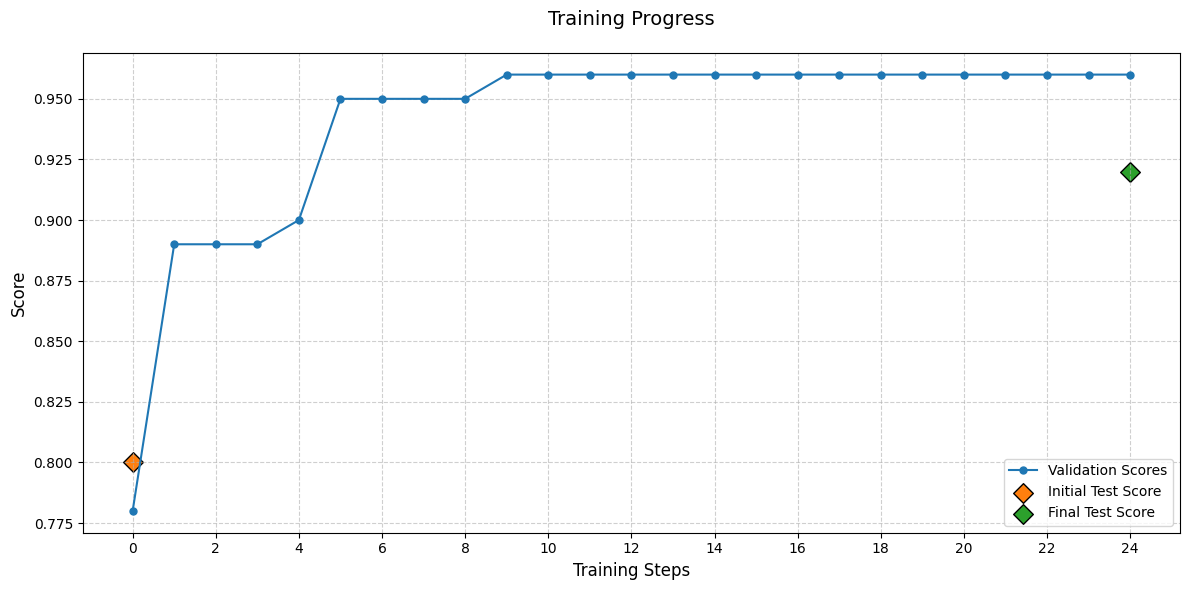

In [ ]:
file = "/root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_9fea9_run_1.json"

plot_training_single(file)

# we see that LLM-AutoDiff is great enough that there is no extra gain from few-shot learning in this run.


# 🚀 We can optimize any LLM workflow

We support auto-optimize on RAG and agent.

* [RAG](https://colab.research.google.com/github/SylphAI-Inc/AdalFlow/blob/main/notebooks/use_cases/adalflow_rag_optimization.ipynb)
* [Multi-hop RAG](https://github.com/SylphAI-Inc/AdalFlow/blob/main/benchmarks/hotpot_qa/adal_exp/train_multi_hop_rag.py)
* [Agent](https://github.com/SylphAI-Inc/AdalFlow/blob/main/benchmarks/hotpot_qa/adal_exp/train_agent_rag.py)

# 💚 [Optional] Train DeepSeek R1 models

In [ ]:
# You can try to train deepseek r1 from together ai

# reasoning models are too slow
!pip install together
clear_output()

deepseek_r1_small = {
    "model_client": adal.TogetherClient(),
    "model_kwargs": {
        "model": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    },
}

# val 0.64 -> 0.85, test: 0.63 -> 0.72
train(task_model_config=deepseek_r1_small, optimizer_model_config=gpt_o3_mini_model)

raw_shots: 1, bootstrap_shots: 1
BootstrapFewShot: ['llm_counter.few_shot_demos']
2025-02-10 05:19:15 - [adal.py:852:configure_text_optimizer_helper] - Text optimizer configured for 1 parameters. names: [('llm_counter.system_prompt', "You will answer a reasoning question. Think step by step. The last line of your response should be of the following format: 'Answer: $VALUE' where VALUE is a numerical value.")]
Configuring teacher generator.
Configuring teacher generator for Generator(
  model_kwargs={'model': 'o3-mini', 'temperature': 1.0}, trainable_prompt_kwargs=[], prompt=template: <START_OF_SYSTEM_PROMPT>
  {{system_prompt}}
  {# Few shot demos #}
  {% if few_shot_demos is not none %}
  Here are some examples:
  {{few_shot_demos}}
  {% endif %}
  <END_OF_SYSTEM_PROMPT>
  <START_OF_USER>
  {{input_str}}
  <END_OF_USER>
  , prompt_kwargs: {'system_prompt': "You will answer a reasoning question. Think step by step. The last line of your response should be of the following format: 'Answ


Loading Data: 100%|██████████| 100/100 [00:00<00:00, 6236.33it/s]
Predicting: step(0): 0.64 across 100 samples, Max potential: 0.64: 100%|██████████| 100/100 [02:47<00:00,  1.67s/it]

Loading Data: 100%|██████████| 100/100 [00:00<00:00, 649.83it/s]
Predicting: step(0): 0.63 across 100 samples, Max potential: 0.63: 100%|██████████| 100/100 [01:54<00:00,  1.15s/it]


Initial validation score: 0.64
Initial test score: 0.63
_fit_text_grad_random save to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json
num_epochs: 1, max_steps: 12



Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0


Training Step: 1:   0%|          | 0/13 [00:00<?, ?it/s]

Training: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 4355.46it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 2352.06it/s]

Proposal: 1


2025-02-10 05:24:31 - [trainer.py:1690:_random_propose_step] - Propose time: 6.855257034301758
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. For the purpose of this problem, treat all items mentioned as animals even if common classifications might differ. The last line of your response should be of the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 779.97it/s]
Predicting: step(1): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


2025-02-10 05:24:34 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 0.75





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 6042.36it/s]
Predicting: step(1): 0.617 across 94 samples, Max potential: 0.64:  94%|█████████▍| 94/100 [01:40<00:06,  1.07s/it]


Proposing:  20%|██        | 1/5 [01:50<07:21, 110.36s/it]

Optimizer revert: 0.6105263157894737 <= 0.64
Proposal: 2
2025-02-10 05:26:20 - [trainer.py:1690:_random_propose_step] - Propose time: 5.574687480926514
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. If the question asks about counting animals, treat every listed item as an animal, regardless of common classifications. The last line of your response should be in the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1549.00it/s]
Predicting: step(1): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


2025-02-10 05:26:23 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 0.75





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 2805.10it/s]
Predicting: step(1): 0.67 across 100 samples, Max potential: 0.67: 100%|██████████| 100/100 [01:54<00:00,  1.14s/it]
Training Step: 2:   8%|▊         | 1/13 [04:20<52:01, 260.12s/it]

Optimizer step: 0.67 > 0.64
 1, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 1315.03it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 5643.19it/s]

Proposal: 1


2025-02-10 05:28:49 - [trainer.py:1690:_random_propose_step] - Propose time: 6.843338489532471
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. When the question asks about counting a specific category (such as animals, vegetables, objects, musical instruments, etc.), treat every explicitly mentioned item as a member of that category, regardless of common classifications. Ensure that no items are missed, including singular ones like 'a toaster'. The last line of your response should be in the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1356.94it/s]
Predicting: step(2): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


2025-02-10 05:28:51 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 6695.46it/s]
Predicting: step(2): 0.6333 across 90 samples, Max potential: 0.67:  90%|█████████ | 90/100 [01:35<00:10,  1.06s/it]


Proposing:  20%|██        | 1/5 [01:44<06:57, 104.41s/it]

Optimizer revert: 0.6263736263736264 <= 0.67
Proposal: 2
2025-02-10 05:30:35 - [trainer.py:1690:_random_propose_step] - Propose time: 8.389176368713379
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step and ensure you meticulously extract every item mentioned in the question, regardless of its typical classification. For example, if the text includes items such as 'a toaster' or 'an onion', each must be counted as one. The last line of your response must be in the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1627.59it/s]
Predicting: step(2): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


Proposing:  40%|████      | 2/5 [01:55<02:27, 49.31s/it] 

2025-02-10 05:30:37 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.5 <= 0.5
Proposal: 3
2025-02-10 05:30:44 - [trainer.py:1690:_random_propose_step] - Propose time: 6.341917514801025
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. If the question asks about counting a category of items, count every mentioned item, regardless of conventional classifications. This means that even if an item does not typically belong to the stated category, it must be included in the tally. The last line of your response should be in the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1428.82it/s]
Predicting: step(2): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


2025-02-10 05:30:46 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5735.41it/s]
Predicting: step(2): 0.5976 across 82 samples, Max potential: 0.67:  82%|████████▏ | 82/100 [00:31<00:06,  2.59it/s]


Proposing:  60%|██████    | 3/5 [02:35<01:30, 45.29s/it]

Optimizer revert: 0.5903614457831325 <= 0.67
Proposal: 4
2025-02-10 05:31:34 - [trainer.py:1690:_random_propose_step] - Propose time: 16.094114303588867
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. When counting items, count every item mentioned without applying standard category filters. That is, include every item—even those not typically classified under the requested category—in your count. The final line of your response must be exactly: 'Answer: $VALUE', where VALUE is the total count.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 572.56it/s]
Predicting: step(2): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


2025-02-10 05:31:37 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.5





Predicting: step(0): 0.9831 across 59 samples, Max potential: 0.99:  59%|█████▉    | 59/100 [30:26<21:09, 30.95s/it]
Training:   0%|          | 0/4 [17:38<?, ?it/s]
Predicting: step(0): 0.0 across 61 samples, Max potential: 0.39:  61%|██████    | 61/100 [17:36<11:15, 17.32s/it]
Predicting: step(0): 0.9583 across 96 samples, Max potential: 0.96:  96%|█████████▌| 96/100 [16:08<00:40, 10.09s/it]
Training:   0%|          | 0/4 [13:31<?, ?it/s]



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 128.92it/s]
Predicting: step(2): 0.6292 across 89 samples, Max potential: 0.67:  89%|████████▉ | 89/100 [00:27<00:03,  3.19it/s]


Proposing:  80%|████████  | 4/5 [03:23<00:46, 46.17s/it]

Optimizer revert: 0.6222222222222222 <= 0.67
Proposal: 5
2025-02-10 05:32:16 - [trainer.py:1690:_random_propose_step] - Propose time: 10.161373138427734
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. When the question involves counting a specific category (such as animals, vegetables, objects, musical instruments, etc.), count every explicitly mentioned item as belonging to that category, without filtering based on common or conventional classifications. For example, even if an item like a toaster or onions is mentioned and traditionally might not be considered in that category, you must count it. The last line of your response must strictly be in the format: 'Answer: $VALUE', where $VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 604.30it/s]
Predicting: step(2): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


2025-02-10 05:32:18 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 7409.25it/s]
Predicting: step(2): 0.6292 across 89 samples, Max potential: 0.67:  89%|████████▉ | 89/100 [00:29<00:03,  3.03it/s]


Training Step: 3:  15%|█▌        | 2/13 [08:49<48:42, 265.65s/it]

Optimizer revert: 0.6222222222222222 <= 0.67
No proposal can improve the subset and full set, and val set
 2, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 1634.41it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 6927.01it/s]

Proposal: 1


2025-02-10 05:33:19 - [trainer.py:1690:_random_propose_step] - Propose time: 6.153940677642822
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step, ensuring that any quantitative descriptors (e.g., 'two heads of broccoli') are counted according to the numbers provided. If the question asks about counting animals, treat every listed item as an animal regardless of common classifications. The last line of your response must be in the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 492.40it/s]
Predicting: step(3): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


Proposing:  20%|██        | 1/5 [00:08<00:34,  8.64s/it]

2025-02-10 05:33:22 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 0.75
Proposal: 2
2025-02-10 05:33:29 - [trainer.py:1690:_random_propose_step] - Propose time: 7.510573625564575
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' indicates 2 items), multiply the descriptor with the item count; if no quantity is mentioned, count the item as one. If the question asks about counting animals, treat every listed item as an animal, regardless of common classifications. The last line of your response should be in the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1261.16it/s]
Predicting: step(3): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


2025-02-10 05:33:31 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 0.75





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 11484.64it/s]
Predicting: step(3): 0.74 across 100 samples, Max potential: 0.74: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]
Training Step: 4:  23%|██▎       | 3/13 [11:01<34:06, 204.64s/it]

Optimizer step: 0.74 > 0.67
 3, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 7553.90it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 5119.69it/s]

Proposal: 1


2025-02-10 05:35:34 - [trainer.py:1690:_random_propose_step] - Propose time: 15.424284934997559
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. For every item mentioned, if a quantitative descriptor (a numeral or number word) immediately precedes the item, count that item as the corresponding number; if no quantity is provided, count it as 1. Ensure that items with a quantitative descriptor are multiplied by that value. If the question asks about counting animals, treat each listed item as an animal regardless of common classifications. The final line of your response must exactly follow this format: 'Answer: $VALUE' where VALUE is the computed numerical total.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1087.17it/s]
Predicting: step(4): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Proposing:  20%|██        | 1/5 [00:18<01:14, 18.71s/it]

2025-02-10 05:35:37 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.5 <= 0.75
Proposal: 2
2025-02-10 05:35:47 - [trainer.py:1690:_random_propose_step] - Propose time: 9.839238166809082
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. For each item listed in the question, if it has a numerical descriptor (expressed either as digits or in words, e.g., '3' or 'three'), count that item using the indicated number; if no numerical descriptor is present (e.g., when preceded by 'a' or 'an'), count the item as one. If the question asks about counting animals, treat every listed item as an animal, regardless of common classifications. Ensure your final line is exactly in the following format: 'Answer: $VALUE' where VALUE is the numerical total.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.f




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 424.34it/s]
Predicting: step(4): 0.25 across 4 samples, Max potential: 0.25: 100%|██████████| 4/4 [01:35<00:00, 23.78s/it]


Proposing:  40%|████      | 2/5 [02:03<03:28, 69.56s/it]

2025-02-10 05:37:22 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.25 <= 0.75
Proposal: 3
2025-02-10 05:37:32 - [trainer.py:1690:_random_propose_step] - Propose time: 9.058738708496094
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. When encountering items with quantitative descriptors (e.g., 'three yams' should count as 3 items), multiply the descriptor with the item count. If no quantity is specified, count the item as one. If the question involves counting animals, treat every listed item as an animal, regardless of common classifications. For example, if the question states 'a carrot, an onion, three yams, a garlic, a head of broccoli, and a potato', calculate the total as 1 + 1 + 3 + 1 + 1 + 1 = 8. The final line of your response must be in the format: 'Answer: $VALUE', where VALUE is a numerical value.", requires_opt=Tru




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 763.47it/s]
Predicting: step(4): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


2025-02-10 05:37:36 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 0.75





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 9857.12it/s]
Predicting: step(4): 0.6829 across 82 samples, Max potential: 0.74:  82%|████████▏ | 82/100 [02:55<00:38,  2.14s/it]


Proposing:  60%|██████    | 3/5 [05:13<04:08, 124.24s/it]

Optimizer revert: 0.6746987951807228 <= 0.74
Proposal: 4
2025-02-10 05:40:40 - [trainer.py:1690:_random_propose_step] - Propose time: 8.38532829284668
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning counting question. Think step by step. If an item is preceded by a numerical descriptor (e.g., 'three yams' or '2 apples'), count that item using the given number; if no number is mentioned, count it as one. For counting animals, treat every listed item as an animal regardless of typical classifications. The final line of your response must be in the format: 'Answer: $VALUE' where $VALUE is the numerical total.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 981.93it/s]
Predicting: step(4): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it]


Proposing:  80%|████████  | 4/5 [05:28<01:21, 81.13s/it] 

2025-02-10 05:40:47 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.5 <= 0.75
Proposal: 5
2025-02-10 05:40:54 - [trainer.py:1690:_random_propose_step] - Propose time: 6.865588665008545
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step and verify your arithmetic. For each listed item, if a quantitative descriptor is present (e.g., 'two', 'three', '4'), multiply that number with the count of that item (so 'three yams' means 3 yams, not 1), otherwise count the item as 1. When counting animals, treat every listed item as one animal regardless of common classifications. Once all items are processed, double-check your total sum. Finally, output the result on a separate line exactly in the following format: 'Answer: $VALUE', where $VALUE is the numerical total.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', n




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2521.37it/s]
Predicting: step(4): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Training Step: 5:  31%|███       | 4/13 [17:00<39:48, 265.44s/it]

2025-02-10 05:40:58 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.5 <= 0.75
No proposal can improve the subset and full set, and val set
 4, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 7688.92it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 942.81it/s]

Proposal: 1


2025-02-10 05:41:55 - [trainer.py:1690:_random_propose_step] - Propose time: 10.055437564849854
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' indicates 2 items), multiply the descriptor with the item count; if no quantity is mentioned, count the item as one. If the question asks about counting animals, treat every listed item as an animal, regardless of common classifications. Before finalizing your response, double-check your arithmetic calculations to verify that all multiplications and additions are correct. The last line of your response should be in the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 2292.28it/s]
Predicting: step(5): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


2025-02-10 05:41:58 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3706.82it/s]
Predicting: step(5): 0.6061 across 66 samples, Max potential: 0.74:  66%|██████▌   | 66/100 [01:59<01:01,  1.80s/it]


Proposing:  20%|██        | 1/5 [02:11<08:46, 131.68s/it]

Optimizer revert: 0.5970149253731343 <= 0.74
Proposal: 2
2025-02-10 05:44:14 - [trainer.py:1690:_random_propose_step] - Propose time: 17.45609474182129
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step and perform precise arithmetic calculations. For items with quantitative descriptors (e.g., 'two heads of broccoli' means 2 items), multiply the quantity accordingly; if no quantity is mentioned, count the item as one. After performing any multiplications, carefully recheck your addition to ensure the sum is correct. If the question asks about counting animals, treat every listed item as an animal regardless of usual classifications. The final line of your response must be in the following format: 'Answer: $VALUE' where $VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requi




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 444.71it/s]
Predicting: step(5): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


2025-02-10 05:44:17 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3780.49it/s]
Predicting: step(5): 0.6533 across 75 samples, Max potential: 0.74:  75%|███████▌  | 75/100 [01:15<00:25,  1.01s/it]


Proposing:  40%|████      | 2/5 [03:47<05:32, 110.69s/it]

Optimizer revert: 0.6447368421052632 <= 0.74
Proposal: 3
2025-02-10 05:45:42 - [trainer.py:1690:_random_propose_step] - Propose time: 9.160748481750488
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. When the question includes items with quantitative descriptors (for example, 'two heads of broccoli' means 2 items), multiply the number by the count of items; if no quantity is mentioned, count the item as one. After applying the multiplier for each item, sum the results and double-check your arithmetic to ensure accuracy. For instance, if the input is 'a carrot, two apples, and four bananas', calculate as follows: carrot = 1, apples = 2, bananas = 4, so the total is 1 + 2 + 4 = 7. If the question asks about counting animals, treat every listed item as an animal regardless of common categorizations. The final line of your response should be in the format: 'Answer: $VALUE'




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 649.25it/s]
Predicting: step(5): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


Proposing:  60%|██████    | 3/5 [03:59<02:10, 65.45s/it] 

2025-02-10 05:45:45 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.5 <= 0.5
Proposal: 4
2025-02-10 05:45:58 - [trainer.py:1690:_random_propose_step] - Propose time: 13.701833009719849
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. When an item has a quantitative descriptor (e.g., 'two apples' means 2 apples, 'four grapes' means 4 grapes), multiply it by the item count; if no quantity is given, count it as one. For counting animals, consider every listed item as an animal. Sum all counts accurately. End your response with a final line in this exact format: 'Answer: $VALUE', where VALUE is the computed total.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 468.47it/s]
Predicting: step(5): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


2025-02-10 05:46:01 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3746.08it/s]
Predicting: step(5): 0.6438 across 73 samples, Max potential: 0.74:  73%|███████▎  | 73/100 [01:30<00:33,  1.24s/it]


Proposing:  80%|████████  | 4/5 [05:46<01:21, 81.89s/it]

Optimizer revert: 0.6351351351351351 <= 0.74
Proposal: 5
2025-02-10 05:47:38 - [trainer.py:1690:_random_propose_step] - Propose time: 5.946806192398071
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' indicates 2 items), multiply the descriptor with the item count; if no quantity is mentioned, count the item as one. If the question asks about counting animals, treat every listed item as an animal, regardless of common classifications. As you work through the problem, perform a clear multiplication for items with numerical descriptors and then reverify your arithmetic summing all items to confirm accuracy. The last line of your response should be in the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9d




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 394.65it/s]
Predicting: step(5): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


2025-02-10 05:47:40 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4735.15it/s]
Predicting: step(5): 0.7011 across 87 samples, Max potential: 0.74:  87%|████████▋ | 87/100 [01:38<00:14,  1.13s/it]


Training Step: 6:  38%|███▊      | 5/13 [25:21<46:42, 350.30s/it]

Optimizer revert: 0.6931818181818182 <= 0.74
No proposal can improve the subset and full set, and val set
 5, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.81it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 9357.06it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 5767.35it/s]

Proposal: 1


2025-02-10 05:49:47 - [trainer.py:1690:_random_propose_step] - Propose time: 10.745105743408203
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' indicates 2 items), multiply the descriptor with the item count; if no quantity is mentioned, count the item as one. If the question asks about counting animals, treat every listed item as an animal, regardless of common classifications. Additionally, if your reasoning process involves more than three steps, update your final answer more rapidly and concisely. The last line of your response should be in the following format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 523.90it/s]
Predicting: step(6): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


Proposing:  20%|██        | 1/5 [00:13<00:53, 13.44s/it]

2025-02-10 05:49:50 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 0.75
Proposal: 2
2025-02-10 05:50:02 - [trainer.py:1690:_random_propose_step] - Propose time: 12.391846656799316
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step by step. When the question includes items with quantitative descriptors (for example, 'two heads of broccoli' means 2 items), multiply the descriptor with each item; if no quantity is mentioned, count the item as one. Additionally, if your chain-of-thought involves more than three distinct reasoning steps, update your final numerical total more rapidly to avoid aggregation errors. If the question asks about counting animals, treat every listed item as an animal, regardless of common classifications. The last line of your response must be in the format: 'Answer: $VALUE' where VALUE is the computed numerical




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1579.92it/s]
Predicting: step(6): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


Proposing:  40%|████      | 2/5 [00:28<00:43, 14.50s/it]

2025-02-10 05:50:05 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 0.75
Proposal: 3
2025-02-10 05:50:17 - [trainer.py:1690:_random_propose_step] - Propose time: 11.581538915634155
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question. Think step by step. When the question includes items with quantitative descriptors (e.g., \'two heads of broccoli\' indicates 2 items), multiply the descriptor with the item count; if no quantity is mentioned, count the item as one. If the question asks about counting animals, treat every listed item as an animal, regardless of common classifications. Additionally, if your chain-of-thought involves more than three reasoning steps, update your computed total more rapidly to minimize cumulative errors. The last line of your response should be in the following format: \'Answer: $VALUE\' where VALUE is a numerical value.




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 378.83it/s]
Predicting: step(6): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:48<00:00, 12.12s/it]


Proposing:  60%|██████    | 3/5 [01:28<01:10, 35.39s/it]

2025-02-10 05:51:05 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 0.75
Proposal: 4
2025-02-10 05:51:17 - [trainer.py:1690:_random_propose_step] - Propose time: 11.626081466674805
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step-by-step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' means 2 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as one. If the question involves counting animals, treat every item as an animal. If your chain-of-thought exceeds three steps, update the aggregate count rapidly. The final line of your response must follow this format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 615.02it/s]
Predicting: step(6): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


2025-02-10 05:51:19 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 0.75





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 6073.77it/s]
Predicting: step(6): 0.76 across 100 samples, Max potential: 0.76: 100%|██████████| 100/100 [00:33<00:00,  2.98it/s]
Training Step: 7:  46%|████▌     | 6/13 [27:55<33:06, 283.76s/it]

Optimizer step: 0.76 > 0.74
 6, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 876.46it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 6154.52it/s]

Proposal: 1


2025-02-10 05:52:32 - [trainer.py:1690:_random_propose_step] - Propose time: 11.3374662399292
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step-by-step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' means 2 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as one. For counting food items such as vegetables or fruits, count every item mentioned (including yam, cauliflower, etc.) unless it clearly does not belong to a food category (e.g., 'bed', 'oven', 'toaster'). If the question involves counting animals, treat every item as an animal. If your chain-of-thought exceeds three steps, update the aggregate count rapidly. The final line of your response must follow this format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 456.40it/s]
Predicting: step(7): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


2025-02-10 05:52:34 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5488.71it/s]
Predicting: step(7): 0.7419 across 93 samples, Max potential: 0.76:  93%|█████████▎| 93/100 [00:31<00:02,  2.95it/s]


Proposing:  20%|██        | 1/5 [00:45<03:02, 45.68s/it]

Optimizer revert: 0.7340425531914894 <= 0.76
Proposal: 2
2025-02-10 05:53:18 - [trainer.py:1690:_random_propose_step] - Propose time: 11.426100492477417
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step-by-step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' means 2), multiply the descriptor by the item count; if no quantity is mentioned, count the item as one. For food items (such as vegetables or fruits), count every item mentioned as belonging to that food category regardless of common classifications (for example, include yam and cauliflower as vegetables) unless the item is clearly non-food (e.g., bed, oven, toaster). If the question involves counting animals, treat every listed item as one animal. If your chain-of-thought exceeds three steps, update the aggregate count rapidly. The final line of your response must follow this f




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1065.63it/s]
Predicting: step(7): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]


2025-02-10 05:53:20 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4989.36it/s]
Predicting: step(7): 0.6129 across 62 samples, Max potential: 0.76:  62%|██████▏   | 62/100 [01:06<00:40,  1.07s/it]


Proposing:  40%|████      | 2/5 [02:05<03:17, 65.96s/it]

Optimizer revert: 0.6031746031746031 <= 0.76
Proposal: 3
2025-02-10 05:54:35 - [trainer.py:1690:_random_propose_step] - Propose time: 8.249132871627808
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step-by-step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' means 2 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as one. For food-related questions (e.g., vegetables or fruits), count every item that appears to be edible, including items such as yam, cauliflower, garlic, and carrot, without reclassifying them based on common misconceptions; exclude only items that are clearly non-food (like bed, oven, toaster). If your chain-of-thought exceeds three steps, update the aggregate count rapidly. The final line of your response must follow this format: 'Answer: $VALUE' where VALUE is a numerical




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 830.10it/s]
Predicting: step(7): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


2025-02-10 05:54:38 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 6616.87it/s]
Predicting: step(7): 0.4894 across 47 samples, Max potential: 0.76:  47%|████▋     | 47/100 [03:51<04:20,  4.92s/it]


Proposing:  60%|██████    | 3/5 [06:08<04:53, 146.59s/it]

Optimizer revert: 0.4791666666666667 <= 0.76
Proposal: 4
2025-02-10 05:58:47 - [trainer.py:1690:_random_propose_step] - Propose time: 18.104076147079468
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step-by-step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' indicates 2 items), use the given numerical value; if no quantity is specified, count the item as one. When the question asks about counting items in a specific category (such as vegetables, fruits, or animals), count every listed item as belonging to that category without reinterpreting based on common classifications—exclude only items that are unmistakably non-food objects (e.g., beds, ovens, toasters, musical instruments). When counting animals, treat every listed item as an animal. If your chain-of-thought exceeds three steps, update the aggregate count rapidly. The final li




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 530.56it/s]
Predicting: step(7): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


2025-02-10 05:58:50 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.5





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5773.70it/s]
Predicting: step(7): 0.6129 across 62 samples, Max potential: 0.76:  62%|██████▏   | 62/100 [00:56<00:34,  1.10it/s]


Proposing:  80%|████████  | 4/5 [07:25<01:59, 119.22s/it]

Optimizer revert: 0.6031746031746031 <= 0.76
Proposal: 5
2025-02-10 06:00:02 - [trainer.py:1690:_random_propose_step] - Propose time: 15.783747911453247
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Process the input text to count items using these rules: if an item includes a quantitative descriptor (e.g., 'two heads of broccoli' means 2 items), use that value; if no number is provided, count it as 1. For food-related questions (such as vegetables or fruits), count every food item mentioned (including yam and cauliflower) unless it is unmistakably non-food (e.g., bed, oven, toaster). For animal-related questions, treat every listed item as an animal. If your step-by-step reasoning exceeds three steps, update the total count immediately. Finally, on a new line, output exactly: 'Answer: $VALUE', where VALUE is the numerical result.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 530.81it/s]
Predicting: step(7): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Training Step: 8:  54%|█████▍    | 7/13 [36:07<35:10, 351.79s/it]

2025-02-10 06:00:05 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.5 <= 0.5
No proposal can improve the subset and full set, and val set
 7, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 779.28it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 2518.72it/s]

Proposal: 1


2025-02-10 06:00:30 - [trainer.py:1690:_random_propose_step] - Propose time: 5.264029502868652
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step-by-step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' means 2 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as one. If the question involves counting animals, treat every item as an animal. If your chain-of-thought involves more than three steps, update the aggregate count rapidly. The final line of your response must follow this format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 496.41it/s]
Predicting: step(8): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Proposing:  20%|██        | 1/5 [00:07<00:31,  7.94s/it]

2025-02-10 06:00:32 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 2
2025-02-10 06:00:41 - [trainer.py:1690:_random_propose_step] - Propose time: 8.584378480911255
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step-by-step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' means 2 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as one. If the question involves counting animals, treat every item as an individual animal. As you work through your chain-of-thought, if you exceed three steps, update the aggregate count rapidly to ensure accuracy. For example, if your reasoning involves listing items in steps, after the third step immediately update your running total before proceeding. The final line of your response must follow this 




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 742.78it/s]
Predicting: step(8): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


Proposing:  40%|████      | 2/5 [00:19<00:29,  9.91s/it]

2025-02-10 06:00:44 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.5 <= 1.0
Proposal: 3
2025-02-10 06:00:51 - [trainer.py:1690:_random_propose_step] - Propose time: 7.623192310333252
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="Answer a reasoning question step-by-step. Multiply any quantitative descriptor (e.g., 'two heads of broccoli' means 2) by its count; if no number is provided, count the item as 1. When counting animals, treat every item as an animal. If your reasoning consists of more than three steps, update the aggregate count immediately. End your response with: 'Answer: $VALUE', where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=True)]





Loading Data: 100%|██████████| 4/4 [00:00<00:00, 640.18it/s]
Predicting: step(8): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


Proposing:  60%|██████    | 3/5 [00:29<00:20, 10.01s/it]

2025-02-10 06:00:54 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 4
2025-02-10 06:01:02 - [trainer.py:1690:_random_propose_step] - Propose time: 8.366514205932617
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step-by-step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' means 2 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as one. If the question involves counting animals, treat every item as an animal. When your chain-of-thought extends beyond three steps, update the aggregate count immediately after any additional step and perform a quick self-check for consistency. The final line of your response must follow this format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id='20eccfe6-5b4f-




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 404.09it/s]
Predicting: step(8): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Proposing:  80%|████████  | 4/5 [00:40<00:10, 10.45s/it]

2025-02-10 06:01:05 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 5
2025-02-10 06:01:25 - [trainer.py:1690:_random_propose_step] - Propose time: 19.851444959640503
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data="You will answer a reasoning question. Think step-by-step. When the chain-of-thought involves more than three steps, group your reasoning into bullet points and update the running total in each group rapidly instead of summing step-by-step. When the question includes items with quantitative descriptors (e.g., 'two heads of broccoli' means 2 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as one. If the question involves counting animals, treat every item as an animal. The final line of your response must follow this format: 'Answer: $VALUE' where VALUE is a numerical value.", requires_opt=True), PromptData(id=




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1758.25it/s]
Predicting: step(8): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Training Step: 9:  62%|██████▏   | 8/13 [37:30<22:10, 266.10s/it]

2025-02-10 06:01:28 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
No proposal can improve the subset and full set, and val set
 8, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json




Training: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 995.21it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 2812.14it/s]

Proposal: 1


2025-02-10 06:02:07 - [trainer.py:1690:_random_propose_step] - Propose time: 8.396707534790039
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question. Think step-by-step. When the question includes items with quantitative descriptors (for example, \'two heads of broccoli\' means multiply the descriptor by the item count), multiply the number provided by the item count; if no quantity is mentioned, count the item as one. When the question involves counting animals, treat every listed item as an animal, including birds. If your chain-of-thought exceeds three steps, update the aggregate count rapidly after each step to avoid cumulative errors. The final line of your response must follow this exact format: \'Answer: "VALUE"\' where VALUE is the computed total expressed as a string.', requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 621.89it/s]
Predicting: step(9): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


2025-02-10 06:02:10 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.75 > 0.25





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5406.84it/s]
Predicting: step(9): 0.6883 across 77 samples, Max potential: 0.76:  77%|███████▋  | 77/100 [01:37<00:29,  1.26s/it]


Proposing:  20%|██        | 1/5 [01:48<07:15, 108.89s/it]

Optimizer revert: 0.6794871794871795 <= 0.76
Proposal: 2
2025-02-10 06:03:55 - [trainer.py:1690:_random_propose_step] - Propose time: 8.134210586547852
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question. Think step-by-step. When the question mentions items with quantitative descriptors (for example, \'three yams\' signifies 3 items and \'two heads of broccoli\' indicates 2 items), multiply the descriptor by the item count; if no quantity is specified, count the item as one. In questions about animals, count every item as an animal, including birds. Additionally, if your chain-of-thought extends beyond three steps, update the aggregate count rapidly to maintain accuracy. Finally, output your final answer as a string enclosed in quotes, following this exact format: \'Answer: "$VALUE"\' where $VALUE is the numerical total.', requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 794.90it/s]
Predicting: step(9): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


2025-02-10 06:03:59 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 0.25





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4491.12it/s]
Predicting: step(9): 0.6522 across 69 samples, Max potential: 0.76:  69%|██████▉   | 69/100 [01:04<00:28,  1.07it/s]


Proposing:  40%|████      | 2/5 [03:05<04:29, 89.77s/it] 

Optimizer revert: 0.6428571428571429 <= 0.76
Proposal: 3
2025-02-10 06:05:14 - [trainer.py:1690:_random_propose_step] - Propose time: 10.843122720718384
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (e.g., \'three yams\' means 3 items), multiply the descriptor to count that many items; if no quantity is mentioned, count the item as 1. When counting animals, treat every listed item as an animal (including birds). If your chain-of-thought exceeds three steps, update your running total rapidly using the multiplied values. Finally, output your answer on the last line exactly in the following format: Answer: "<VALUE>", where <VALUE> is the computed total written as a string.\n\nExample:\nInput: "I have three yams, a potato, and two carrots."\nReasoning: 3 (yams) + 1 (potato) + 2 (




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 403.08it/s]
Predicting: step(9): 0.5 across 4 samples, Max potential: 0.5: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


2025-02-10 06:05:18 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 0.5 > 0.25





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3521.90it/s]
Predicting: step(9): 0.79 across 100 samples, Max potential: 0.79: 100%|██████████| 100/100 [02:08<00:00,  1.29s/it]
Training Step: 10:  69%|██████▉   | 9/13 [43:30<19:41, 295.45s/it]

Optimizer step: 0.79 > 0.76
 9, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json




Training: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 8599.29it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 1838.60it/s]

Proposal: 1


2025-02-10 06:07:56 - [trainer.py:1690:_random_propose_step] - Propose time: 10.388625383377075
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (e.g., \'three yams\' means 3 items), multiply the descriptor to count that many items; if no quantity is mentioned, count the item as 1. When counting animals, treat every listed item as an animal (including birds). If your chain-of-thought exceeds three steps, update your running total rapidly by incorporating the multiplied values after each step. Finally, output your answer on the last line exactly in the following format: Answer: "<VALUE>", where <VALUE> is the computed total written as a string.', requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_opt=Tr




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 762.67it/s]
Predicting: step(10): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.57it/s]


2025-02-10 06:07:59 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4659.72it/s]
Predicting: step(10): 0.7742 across 93 samples, Max potential: 0.79:  93%|█████████▎| 93/100 [00:36<00:02,  2.54it/s]


Proposing:  20%|██        | 1/5 [00:49<03:19, 49.81s/it]

Optimizer revert: 0.7659574468085106 <= 0.79
Proposal: 2
2025-02-10 06:08:44 - [trainer.py:1690:_random_propose_step] - Propose time: 9.196558952331543
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a detailed, step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' implies 3 items), multiply this number by the count of items; if no quantity is mentioned, treat the item as 1. When the question involves counting animals, count every listed item as an animal (including birds). IMPORTANT: If your chain-of-thought extends beyond three steps, update your running total more frequently with the multiplied values. Finally, provide your answer on the very last line exactly as follows: Answer: "<VALUE>", where <VALUE> is the computed total expressed as a string.\n\nExample:\nInput: "I have three yams, a potato, and




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 775.36it/s]
Predicting: step(10): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


2025-02-10 06:08:47 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4504.63it/s]
Predicting: step(10): 0.6441 across 59 samples, Max potential: 0.79:  59%|█████▉    | 59/100 [01:19<00:55,  1.35s/it]


Proposing:  40%|████      | 2/5 [02:21<03:43, 74.53s/it]

Optimizer revert: 0.6333333333333333 <= 0.79
Proposal: 3
2025-02-10 06:10:16 - [trainer.py:1690:_random_propose_step] - Propose time: 9.020878791809082
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. Count each item by multiplying the provided quantitative descriptor (e.g., \'three yams\' equals 3) or counting it as 1 if no quantity is mentioned. For animals, treat every listed item as an animal (including birds). If your chain-of-thought exceeds three steps, immediately update your running total after each step with the multiplied values. Before giving your final answer, verify that your updated total is correct. Output your final answer on the last line exactly in the following format: Answer: "<VALUE>", where <VALUE> is the computed total written as a string.', requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name=




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 681.86it/s]
Predicting: step(10): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Proposing:  60%|██████    | 3/5 [02:33<01:31, 45.82s/it]

2025-02-10 06:10:19 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 4
2025-02-10 06:10:29 - [trainer.py:1690:_random_propose_step] - Propose time: 10.112003564834595
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You are a meticulous counter with expertise in arithmetic reasoning. Your task is to answer a counting question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (e.g., \'three yams\' means 3 items), multiply the descriptor to count that many items; if no quantity is mentioned, count the item as 1. When counting animals, treat every listed item as an animal. IMPORTANT: If your chain-of-thought involves more than three reasoning steps, update your running total rapidly after each step by incorporating the multiplied values. Finally, output your answer on the last line exactly in the following 




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1000.01it/s]
Predicting: step(10): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


2025-02-10 06:10:31 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5042.87it/s]
Predicting: step(10): 0.7742 across 93 samples, Max potential: 0.79:  92%|█████████▏| 92/100 [01:01<00:04,  1.79it/s]

Proposing:  80%|████████  | 4/5 [03:47<00:57, 57.03s/it]

Optimizer revert: 0.7659574468085106 <= 0.79
Proposal: 5
2025-02-10 06:11:44 - [trainer.py:1690:_random_propose_step] - Propose time: 11.033567428588867
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You are a meticulous counter. Follow these steps to answer the reasoning question:\n• Read the input question carefully.\n• For each item mentioned, if a quantitative descriptor is provided (e.g., \'three yams\' means 3), multiply the quantity by the item count; if no quantity is mentioned, treat the item as 1.\n• When counting animals, count every listed item as an animal (including birds).\n• If your chain-of-thought involves more than three discrete steps, update your running total immediately after each additional step to maintain accuracy.\n• In your final output, present the answer on the last line exactly in this format: Answer: "<VALUE>", where <VALUE> is the computed total written as a string.', requires_opt=True), Prom




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 515.65it/s]
Predicting: step(10): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


2025-02-10 06:11:47 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5672.04it/s]
Predicting: step(10): 0.6038 across 53 samples, Max potential: 0.79:  53%|█████▎    | 53/100 [01:39<01:28,  1.88s/it]


Training Step: 11:  77%|███████▋  | 10/13 [49:29<15:45, 315.18s/it]

Optimizer revert: 0.5925925925925926 <= 0.79
No proposal can improve the subset and full set, and val set
 10, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json




Training: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 1137.44it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 2425.50it/s]

Proposal: 1


2025-02-10 06:14:00 - [trainer.py:1690:_random_propose_step] - Propose time: 9.719079971313477
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each mentioned item, if a quantitative descriptor is provided (e.g., \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. When counting animals, treat every listed item as an animal (including birds). If your chain-of-thought exceeds three steps, update your running total rapidly and ensure that the multiplication factor is correctly applied at every update. Finally, output your answer on the last line exactly in the following format: Answer: "<VALUE>", where <VALUE> is the computed total written as a string.\n\nExample:\nInput: "I have three yams, a potato, and two carrots."\nReasoning: 3 (yams) + 1 (potato) + 2 (carrots) = 6\n




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 1481.96it/s]
Predicting: step(11): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Proposing:  20%|██        | 1/5 [00:12<00:49, 12.36s/it]

2025-02-10 06:14:03 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 0.75
Proposal: 2
2025-02-10 06:14:15 - [trainer.py:1690:_random_propose_step] - Propose time: 11.864533424377441
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When counting animals, treat every listed item as an animal (including birds). Finally, output your answer on the last line exactly in the following format: Answer: "<VALUE>", where <VALUE> is the computed total 




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 965.76it/s]
Predicting: step(11): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


2025-02-10 06:14:19 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 0.75





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 6727.89it/s]
Predicting: step(11): 0.85 across 100 samples, Max potential: 0.85: 100%|██████████| 100/100 [02:26<00:00,  1.47s/it]
Training Step: 12:  85%|████████▍ | 11/13 [52:48<09:18, 279.49s/it]

Optimizer step: 0.85 > 0.79
 11, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json




Training: 100%|██████████| 4/4 [00:02<00:00,  1.90it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 8252.44it/s]


Optimizer propose...




Evaluating: 100%|██████████| 4/4 [00:00<00:00, 1151.25it/s]

Proposal: 1


2025-02-10 06:17:09 - [trainer.py:1690:_random_propose_step] - Propose time: 7.893006086349487
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought process. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3), multiply that number by one (if only one of that item appears) or by the count specified; if no quantity is provided, count the item as 1. When your chain-of-thought has more than three steps, update your running total rapidly by immediately adding the full value computed in that step. When counting animals, treat every listed item as an animal (including birds). Finally, on the last line output your answer in the exact format: Answer: "<VALUE>", where <VALUE> is the computed total expressed as a string.', requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 300.24it/s]
Predicting: step(12): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.61it/s]


Proposing:  20%|██        | 1/5 [00:10<00:42, 10.57s/it]

2025-02-10 06:17:11 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 2
2025-02-10 06:17:22 - [trainer.py:1690:_random_propose_step] - Propose time: 10.714255571365356
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. IMPORTANT: If your chain-of-thought includes more than three steps, update your running total immediately by adding the complete multiplied value for that step before proceeding. When counting animals, treat every listed item as an animal (including birds). Finally, output your answer on the last line exactly in the following format: Answer: "<VALUE>", where <VALUE> is th




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 673.54it/s]
Predicting: step(12): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:42<00:00, 10.57s/it]


2025-02-10 06:18:05 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4395.07it/s]
Predicting: step(12): 0.8387 across 93 samples, Max potential: 0.85:  93%|█████████▎| 93/100 [03:04<00:13,  1.99s/it]


Proposing:  40%|████      | 2/5 [04:08<07:12, 144.29s/it]

Optimizer revert: 0.8297872340425532 <= 0.85
Proposal: 3
2025-02-10 06:21:21 - [trainer.py:1690:_random_propose_step] - Propose time: 12.09911060333252
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought process. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply that descriptor by the item count; if no quantity is mentioned, count the item as 1. When counting animals, treat every listed item as an animal (including birds). In addition, if your chain-of-thought explanation extends beyond three steps, immediately update your running total by adding the computed value for that step before proceeding further. Finally, output your answer on the last line exactly in the following format: Answer: "<VALUE>", where <VALUE> is the computed total expressed as a string.\n\nExample:\nInput: "I have t




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 434.17it/s]
Predicting: step(12): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]


Proposing:  60%|██████    | 3/5 [04:23<02:50, 85.08s/it] 

2025-02-10 06:21:24 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
Proposal: 4
2025-02-10 06:21:31 - [trainer.py:1690:_random_propose_step] - Propose time: 6.758004426956177
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will solve a counting problem using a step-by-step chain-of-thought. For each item: if a quantitative descriptor is present (e.g., \'three yams\' means 3 items), multiply the descriptor; if absent, count it as 1. When your chain-of-thought exceeds three steps, immediately add the computed value for that step to your running total. When counting animals, treat every item (including birds) as an animal. Output your final answer on the last line exactly as: Answer: "<VALUE>", where <VALUE> is the total expressed as a string.', requires_opt=True), PromptData(id='20eccfe6-5b4f-418d-9db0-b1252e4eeb33', name='llm_counter.few_shot_demos', data=None, requires_o




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 378.12it/s]
Predicting: step(12): 1.0 across 4 samples, Max potential: 1.0: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


2025-02-10 06:21:36 - [trainer.py:1707:_random_propose_step] - Pass subset check:False, 1.0 > 1.0





Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5088.88it/s]
Predicting: step(12): 0.6591 across 44 samples, Max potential: 0.85:  44%|████▍     | 44/100 [02:11<02:46,  2.98s/it]


Proposing:  80%|████████  | 4/5 [06:45<01:47, 107.90s/it]

Optimizer revert: 0.6444444444444445 <= 0.85
Proposal: 5
2025-02-10 06:24:00 - [trainer.py:1690:_random_propose_step] - Propose time: 13.549063205718994
New prompts:  [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You are an expert reasoning assistant. You will answer a reasoning question using a clear, step-by-step chain-of-thought. For each listed item, if a quantitative descriptor is provided (for example, ‘three yams’ means 3 items), multiply that number by the item count; if no descriptor is provided, count the item as 1. Critically, if your chain-of-thought extends beyond three steps, immediately update the running total by adding the computed value for that step—ensuring rapid updates. When counting animals, treat every item (including birds) as an animal, regardless of context. Finally, output your answer on the last line exactly in the following format: Answer: "<VALUE>", where <VALUE> is the final computed total expressed as a s




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 421.85it/s]
Predicting: step(12): 0.75 across 4 samples, Max potential: 0.75: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]


Training Step: 12:  92%|█████████▏| 12/13 [1:00:05<05:00, 300.46s/it]

Epoch: 100%|██████████| 1/1 [1:00:05<00:00, 3605.60s/it]


2025-02-10 06:24:03 - [trainer.py:1713:_random_propose_step] - Fail subset check, try next proposal: False, 0.75 <= 1.0
No proposal can improve the subset and full set, and val set
 12, Saving checkpoint to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json
Reached max steps
Starting step: 12
steps [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Configuring teacher generator.
Configuring teacher generator for Generator(
  model_kwargs={'model': 'o3-mini', 'temperature': 1.0}, trainable_prompt_kwargs=[], prompt=template: <START_OF_SYSTEM_PROMPT>
  {{system_prompt}}
  {# Few shot demos #}
  {% if few_shot_demos is not none %}
  Here are some examples:
  {{few_shot_demos}}
  {% endif %}
  <END_OF_SYSTEM_PROMPT>
  <START_OF_USER>
  {{input_str}}
  <END_OF_USER>
  , prompt_kwargs: {'system_prompt': 'You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'


Training Step: 13:   0%|          | 0/12 [00:00<?, ?it/s]

Backward engine disabled for GradComponents
Training Step: 13




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 153.34it/s]


Trace with id 9986e909-6019-4ab7-a42f-05b967fd5461 already exists. Updating the trace.

Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:  25%|██▌       | 1/4 [00:00<00:02,  1.06it/s]

Trace with id cafa5fcf-3ee8-404e-8447-08cd36f9d4bc already exists. Updating the trace.
Trace with id 49704b26-dcb6-47dd-854f-a3118e8045bb already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:01<00:00,  2.23it/s]


Trace with id bbe68a3d-ef56-4082-b2b6-22a904b40586 already exists. Updating the trace.




Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 8293.24it/s]


Training: 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 1231.36it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 = 11\n\nAnswer: "11"'), '9986e909-6019-4ab7-a42f-05b967fd5461': DynamicDataClass(id='9986e909-6019-4ab7-a42f

len_teacher_scores: 4
len_augmented_options: 4
sampled_augmented_demos: ['bbe68a3d-ef56-4082-b2b6-22a904b40586']
2025-02-10 06:24:15 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 5a2aeb7f-252e-4e37-a685-1b38901645d5
question: I have a flute, and an accordion. How many musical instruments do I have?
answer: '2'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When counting animals, treat every listed item as an animal (including birds). Finally, output your answer on the 



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5318.54it/s]
Predicting: step(13): 0.5714 across 35 samples, Max potential: 0.85:  35%|███▌      | 35/100 [03:30<06:31,  6.02s/it]

Training Step: 14:  17%|█▋        | 2/12 [03:42<37:02, 222.27s/it]

Fail validation: 0.5555555555555556 <= 0.85, revert
Training Step: 14




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 126.02it/s]


Trace with id a000c79c-782f-4c96-9c18-781a4bbdca2f already exists. Updating the trace.Trace with id 6d3c3d9a-1a2a-4f20-b460-31f617238e47 already exists. Updating the trace.



Training:  25%|██▌       | 1/4 [00:01<00:03,  1.18s/it]

Trace with id fe40f30e-760b-40ea-b188-9515a2ef9010 already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:01<00:00,  2.85it/s]


Trace with id ea908ec5-4882-456f-96d8-ab31d56dc9c3 already exists. Updating the trace.




Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 1348.33it/s]


Training: 100%|██████████| 4/4 [00:07<00:00,  1.90s/it]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 748.48it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 = 11\n\nAnswer: "11"'), '9986e909-6019-4ab7-a42f-05b967fd5461': DynamicDataClass(id='9986e909-6019-4ab7-a42f-

len_teacher_scores: 8
len_augmented_options: 8
sampled_augmented_demos: ['a000c79c-782f-4c96-9c18-781a4bbdca2f']
2025-02-10 06:27:55 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: e7f2bf98-84bc-4c81-aca8-197ccd22758a
question: I have an orange, three strawberries, an apple, three bananas, three raspberries,
  a peach, a blackberry, a grape, a plum, and two nectarines. How many fruits do I
  have?
answer: '17'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When counting 



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4663.08it/s]
Predicting: step(14): 0.4643 across 28 samples, Max potential: 0.85:  28%|██▊       | 28/100 [11:05<28:31, 23.76s/it]

Training Step: 15:  33%|███▎      | 4/12 [14:57<41:01, 307.74s/it]

Fail validation: 0.4482758620689655 <= 0.85, revert
Training Step: 15




Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id a22238b0-70a5-46d1-a94f-387dcb6bfd74 already exists. Updating the trace.
Trace with id a2729d17-abb1-4401-8777-855884bae3d1 already exists. Updating the trace.
Trace with id c42a1d8f-e08e-4f21-b633-214fe37ecec3 already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


Trace with id 6b3fd927-e5a4-43ed-bba4-8e9192eddc85 already exists. Updating the trace.




Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 2521.37it/s]


Training: 100%|██████████| 4/4 [00:10<00:00,  2.57s/it]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 783.91it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 = 11\n\nAnswer: "11"'), '9986e909-6019-4ab7-a42f-05b967fd5461': DynamicDataClass(id='9986e909-6019-4ab7-a42f-

len_teacher_scores: 12
len_augmented_options: 12
sampled_augmented_demos: ['fe40f30e-760b-40ea-b188-9515a2ef9010']
2025-02-10 06:39:13 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 23765d21-aa8c-42da-87e9-b3d6a84eab16
question: I have a yam, a cauliflower, a bed, two cabbages, a garlic, an oven, a carrot,
  a head of broccoli, a potato, a stalk of celery, a lettuce head, and a toaster.
  How many vegetables do I have?
answer: '10'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for th



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4162.79it/s]
Predicting: step(15): 0.4 across 25 samples, Max potential: 0.85:  25%|██▌       | 25/100 [07:53<23:39, 18.93s/it]

Training Step: 16:  42%|████▏     | 5/12 [23:03<32:00, 274.43s/it]

Fail validation: 0.38461538461538464 <= 0.85, revert
Training Step: 16




Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id 5a2aeb7f-252e-4e37-a685-1b38901645d5 already exists. Updating the trace.


Training:  25%|██▌       | 1/4 [00:01<00:04,  1.37s/it]

Trace with id 71afb833-6b69-4fe6-8d5e-1a0397db8801 already exists. Updating the trace.
Trace with id 187dac84-61df-4371-95c1-2a3decd46d9e already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


Trace with id 0d861e5c-aba5-40b6-89b6-64d14f26e236 already exists. Updating the trace.




Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 7234.68it/s]


Training: 100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 140.97it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 = 11\n\nAnswer: "11"'), '9986e909-6019-4ab7-a42f-05b967fd5461': DynamicDataClass(id='9986e909-6019-4ab7-a42f-

len_teacher_scores: 16
len_augmented_options: 16
sampled_augmented_demos: ['fe40f30e-760b-40ea-b188-9515a2ef9010']
2025-02-10 06:47:16 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: fd612a94-f4ab-4d7c-9a10-b8ccd72fbfdf
question: I have a potato, a yam, two heads of broccoli, and a cauliflower. How many
  vegetables do I have?
answer: '5'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When counting animals, treat every listed item as an animal (including birds). Finally,



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4767.28it/s]
Predicting: step(16): 0.5833 across 36 samples, Max potential: 0.85:  36%|███▌      | 36/100 [06:23<11:21, 10.65s/it]

Training Step: 17:  58%|█████▊    | 7/12 [29:36<25:30, 306.18s/it]

Fail validation: 0.5675675675675675 <= 0.85, revert
Training Step: 17




Loading Data: 100%|██████████| 4/4 [00:00<00:00, 71.15it/s]


Trace with id 2c51ebcf-9582-4b59-a276-1d5ff02af796 already exists. Updating the trace.


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id d5d94b77-df74-429a-86a1-fda94549def9 already exists. Updating the trace.


Training:  50%|█████     | 2/4 [00:01<00:01,  1.40it/s]

Trace with id c9eecf19-5b70-499c-ab14-37f91ef5910d already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


Trace with id 9e513b03-94bf-4802-b8f2-d323183fe5db already exists. Updating the trace.




Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 650.48it/s]


Training: 100%|██████████| 4/4 [00:14<00:00,  3.59s/it]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 398.61it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 = 11\n\nAnswer: "11"'), '9986e909-6019-4ab7-a42f-05b967fd5461': DynamicDataClass(id='9986e909-6019-4ab7-a42f-0

len_teacher_scores: 20
len_augmented_options: 20
sampled_augmented_demos: ['6d3c3d9a-1a2a-4f20-b460-31f617238e47']
2025-02-10 06:53:57 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: c42a1d8f-e08e-4f21-b633-214fe37ecec3
question: I have a fridge, a chair, a bed, an oven, a microwave, and a car. How many
  objects do I have?
answer: '6'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When counting animals, treat every listed item as an animal (including birds). Finally, ou



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3043.50it/s]
Predicting: step(17): 0.7 across 50 samples, Max potential: 0.85:  50%|█████     | 50/100 [03:34<03:34,  4.29s/it]

Training Step: 18:  67%|██████▋   | 8/12 [33:28<14:54, 223.71s/it]

Fail validation: 0.6862745098039216 <= 0.85, revert
Training Step: 18




Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id 54b8c1cd-81ee-47c7-aeb7-bbddf9f046dd already exists. Updating the trace.
Trace with id 5ce36149-fb70-4fd9-ad95-374dbc8edcbf already exists. Updating the trace.
Trace with id 816df5e5-c45f-4484-81ae-32c0a7f27fc2 already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


Trace with id b2513134-e87c-416d-8c5c-a8699b9d99f0 already exists. Updating the trace.




Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 208.63it/s]


Training: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 225.06it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 = 11\n\nAnswer: "11"'), '9986e909-6019-4ab7-a42f-05b967fd5461': DynamicDataClass(id='9986e909-6019-4ab7-a42f-0

len_teacher_scores: 24
len_augmented_options: 24
sampled_augmented_demos: ['816df5e5-c45f-4484-81ae-32c0a7f27fc2']
2025-02-10 06:57:40 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 5ce36149-fb70-4fd9-ad95-374dbc8edcbf
question: I have a blackberry, a plum, and a banana. How many fruits do I have?
answer: '3'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When counting animals, treat every listed item as an animal (including birds). Finally, output your answer on the la



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 7219.86it/s]
Predicting: step(18): 0.5312 across 32 samples, Max potential: 0.85:  32%|███▏      | 32/100 [03:56<08:22,  7.39s/it]

Training Step: 19:  75%|███████▌  | 9/12 [37:33<11:26, 228.78s/it]

Fail validation: 0.5151515151515151 <= 0.85, revert
Training Step: 19




Training:  50%|█████     | 2/4 [00:01<00:01,  1.93it/s]

Trace with id 5d4b0d11-4a35-46fb-af8d-f7a9120675ce already exists. Updating the trace.
Trace with id fd612a94-f4ab-4d7c-9a10-b8ccd72fbfdf already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]


Trace with id 23765d21-aa8c-42da-87e9-b3d6a84eab16 already exists. Updating the trace.




Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 179.37it/s]


Training: 100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Loading Data:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 199.82it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 = 11\n\nAnswer: "11"'), '9986e909-6019-4ab7-a42f-05b967fd

len_teacher_scores: 28
len_augmented_options: 28
sampled_augmented_demos: ['a2729d17-abb1-4401-8777-855884bae3d1']
2025-02-10 07:01:49 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: e06e251d-4b0f-4668-90ce-b018bc2ec930
question: I have a carrot, an onion, a stalk of celery, three yams, a garlic, a head
  of broccoli, and a potato. How many vegetables do I have?
answer: '9'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When counting animals, treat every listed item as a



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 2192.70it/s]
Predicting: step(19): 0.4828 across 29 samples, Max potential: 0.85:  29%|██▉       | 29/100 [09:18<22:47, 19.26s/it]

Training Step: 20:  92%|█████████▏| 11/12 [47:04<05:15, 315.25s/it]

Fail validation: 0.4666666666666667 <= 0.85, revert
Training Step: 20




Training: 100%|██████████| 4/4 [00:01<00:00,  3.38it/s]


Trace with id 92cfdd19-7f31-4c3d-9355-bc714c0da4e5 already exists. Updating the trace.
Trace with id ad30d24d-111c-4995-b89c-790631f8ead4 already exists. Updating the trace.
Trace with id edfce7d8-ca4e-407b-92bf-f0974c58eb26 already exists. Updating the trace.
Trace with id 9533b5c5-fe63-4b26-b3db-9cb19c33d19f already exists. Updating the trace.




Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 2262.91it/s]


Training: 100%|██████████| 4/4 [00:04<00:00,  1.09s/it]


Loading Data:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 160.22it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 = 11\n\nAnswer: "11"'), '9986e909-6019-4ab7-a42f-05b967f

len_teacher_scores: 32
len_augmented_options: 32
sampled_augmented_demos: ['125cf954-f9dc-434d-a21f-0369fe82c215']
2025-02-10 07:11:15 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 187dac84-61df-4371-95c1-2a3decd46d9e
question: I have a flute, a piano, a trombone, four stoves, a violin, an accordion,
  a clarinet, a drum, two lamps, and a trumpet. How many musical instruments do I
  have?
answer: '8'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When counting animals,



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3683.38it/s]
Predicting: step(20): 0.5714 across 35 samples, Max potential: 0.85:  35%|███▌      | 35/100 [06:56<12:53, 11.90s/it]

Training Step: 21: 100%|██████████| 12/12 [54:08<00:00, 271.83s/it]

Fail validation: 0.5555555555555556 <= 0.85, revert
Training Step: 21




Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id 461f044b-9a99-43ba-b4da-7fc99d6c30a5 already exists. Updating the trace.
Trace with id c50ca386-9ea9-4c0e-97a0-6e7877ecf969 already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


Trace with id a2ec1a5e-0f5f-4717-8f9f-316961fc4789 already exists. Updating the trace.
Trace with id 728a1741-1565-42d4-a5cf-d7f8a7f70633 already exists. Updating the trace.




Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 524.81it/s]


Training: 100%|██████████| 4/4 [00:11<00:00,  2.86s/it]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 137.13it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 = 11\n\nAnswer: "11"'), '9986e909-6019-4ab7-a42f-05b967fd5461': DynamicDataClass(id='9986e909-6019-4ab7-a42f-0

len_teacher_scores: 36
len_augmented_options: 36
sampled_augmented_demos: ['0d861e5c-aba5-40b6-89b6-64d14f26e236']
2025-02-10 07:18:25 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: e7f2bf98-84bc-4c81-aca8-197ccd22758a
question: I have an orange, three strawberries, an apple, three bananas, three raspberries,
  a peach, a blackberry, a grape, a plum, and two nectarines. How many fruits do I
  have?
answer: '17'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When countin



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5512.15it/s]
Predicting: step(21): 0.5 across 30 samples, Max potential: 0.85:  30%|███       | 30/100 [09:14<21:33, 18.48s/it]

Training Step: 21: : 13it [1:03:36, 340.20s/it]                    
Training Step: 22: : 13it [1:03:36, 340.20s/it]

Fail validation: 0.4838709677419355 <= 0.85, revert
Training Step: 22




Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id 50ff7d9f-ad07-473a-98ba-6c29097ebb36 already exists. Updating the trace.
Trace with id 347fc96f-e1a0-424b-951d-1e050cdd7f4a already exists. Updating the trace.
Trace with id 7d19ef77-ce9b-41e0-abc1-308c4f91d44f already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 379.27it/s]


Training: 100%|██████████| 4/4 [00:05<00:00,  1.30s/it]


Loading Data:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 251.53it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 =

len_teacher_scores: 40
len_augmented_options: 40
sampled_augmented_demos: ['49704b26-dcb6-47dd-854f-a3118e8045bb']
2025-02-10 07:27:49 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 6d3c3d9a-1a2a-4f20-b460-31f617238e47
question: I have a drum, an accordion, and a violin. How many musical instruments
  do I have?
answer: '3'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When counting animals, treat every listed item as an animal (including birds). Finally, output your a



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 5009.62it/s]
Predicting: step(22): 0.7 across 50 samples, Max potential: 0.85:  50%|█████     | 50/100 [03:22<03:22,  4.04s/it]

Training Step: 22: : 14it [1:07:07, 308.26s/it]
Training Step: 23: : 14it [1:07:07, 308.26s/it]

Fail validation: 0.6862745098039216 <= 0.85, revert
Training Step: 23




Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id e0fce901-c4ea-4590-8d77-3862c72cd846 already exists. Updating the trace.Trace with id e0dcd7a0-2573-4ff7-badc-3e854dbf62b3 already exists. Updating the trace.



Training:  25%|██▌       | 1/4 [00:01<00:03,  1.08s/it]

Trace with id e77c4eea-b9e5-4ef1-a839-473071dfe4f8 already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


Trace with id e7f2bf98-84bc-4c81-aca8-197ccd22758a already exists. Updating the trace.




Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 80.43it/s]


Training: 100%|██████████| 4/4 [00:10<00:00,  2.64s/it]


Loading Data:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 263.69it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 = 11\n\nAnswer: "11"'), '9986e909-6019-4ab7-a42f-05b967fd5

len_teacher_scores: 44
len_augmented_options: 44
sampled_augmented_demos: ['6b3fd927-e5a4-43ed-bba4-8e9192eddc85']
2025-02-10 07:31:25 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: bb5dac78-637b-4a51-8026-8aab8dddc56b
question: I have a cauliflower, a stalk of celery, a cabbage, and a garlic. How many
  vegetables do I have?
answer: '4'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When counting animals, treat every listed item as an animal (including birds). Finally,



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 3188.52it/s]
Predicting: step(23): 0.4444 across 27 samples, Max potential: 0.85:  27%|██▋       | 27/100 [06:56<18:45, 15.41s/it]

Training Step: 23: : 15it [1:14:17, 340.08s/it]
Training Step: 24: : 16it [1:14:17, 340.08s/it]

Fail validation: 0.42857142857142855 <= 0.85, revert
Training Step: 24




Training:   0%|          | 0/4 [00:00<?, ?it/s]

Trace with id 0f943755-5006-4028-9294-6ebcea9f343f already exists. Updating the trace.
Trace with id bb5dac78-637b-4a51-8026-8aab8dddc56b already exists. Updating the trace.
Trace with id 42f4d5d5-07fd-41e2-86b1-5147f4c86f79 already exists. Updating the trace.


Training: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


Trace with id 9cab402a-71d4-404d-badd-4ed98a76a6dd already exists. Updating the trace.




Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 534.97it/s]


Training: 100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


Loading Data:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating Loss: 100%|██████████| 4/4 [00:00<00:00, 769.56it/s]
 {'bbe68a3d-ef56-4082-b2b6-22a904b40586': DynamicDataClass(id='bbe68a3d-ef56-4082-b2b6-22a904b40586', score=1.0, input_str='I have a bear, a dog, a cow, a cat, two pigs, a donkey, a fish, a frog, and two goats. How many animals do I have?', Example='Step 1: Count a bear = 1. Total now = 1  \nStep 2: Count a dog = 1. Total now = 1 + 1 = 2  \nStep 3: Count a cow = 1. Total now = 2 + 1 = 3  \nStep 4: Count a cat = 1. Total now = 3 + 1 = 4  \nStep 5: Count two pigs = 2. Total now = 4 + 2 = 6  \nStep 6: Count a donkey = 1. Total now = 6 + 1 = 7  \nStep 7: Count a fish = 1. Total now = 7 + 1 = 8  \nStep 8: Count a frog = 1. Total now = 8 + 1 = 9  \nStep 9: Count two goats = 2. Total now = 9 + 2 = 11\n\nAnswer: "11"'), '9986e909-6019-4ab7-a42f-05b967fd

len_teacher_scores: 48
len_augmented_options: 48
sampled_augmented_demos: ['edfce7d8-ca4e-407b-92bf-f0974c58eb26']
2025-02-10 07:38:35 - [bootstrap_optimizer.py:226:samples_to_str] - yaml_str: id: 42f4d5d5-07fd-41e2-86b1-5147f4c86f79
question: I have a microwave, a lamp, four cars, a stove, a toaster, and a bed. How
  many objects do I have?
answer: '9'
New prompts: [PromptData(id='8893ca0b-00a7-43f4-be91-a7cccf6ed67b', name='llm_counter.system_prompt', data='You will answer a reasoning question using a step-by-step chain-of-thought approach. For each item mentioned, if a quantitative descriptor is provided (for example, \'three yams\' means 3 items), multiply the descriptor by the item count; if no quantity is mentioned, count the item as 1. Importantly, whenever your chain-of-thought extends beyond three steps, update your running total immediately by adding the full multiplied value for that step. When counting animals, treat every listed item as an animal (including birds). Finally



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 4156.44it/s]
Predicting: step(24): 0.4 across 25 samples, Max potential: 0.85:  25%|██▌       | 25/100 [06:33<19:41, 15.76s/it]

Training Step: 24: 100%|██████████| 12/12 [1:21:05<00:00, 405.49s/it]


Fail validation: 0.38461538461538464 <= 0.85, revert
Saved ckpt to /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json
Training time: 8754.31505227089s



Loading Data: 100%|██████████| 100/100 [00:00<00:00, 2445.69it/s]
Predicting: step(0): 0.72 across 100 samples, Max potential: 0.72: 100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


ckpt_file: /root/.adalflow/ckpt/ObjectCountAdalComponent/random_max_steps_12_576f6_run_1.json


# Issues and feedback

If you encounter any issues, please report them here: [GitHub Issues](https://github.com/SylphAI-Inc/LightRAG/issues).

For feedback, you can use either the [GitHub discussions](https://github.com/SylphAI-Inc/LightRAG/discussions) or [Discord](https://discord.gg/ezzszrRZvT).